In [2]:
import sys
import os.path as op
import warnings

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns

import statsmodels.api as sm
import nibabel as nib

pd.options.display.max_rows = 100
pd.options.display.max_columns = 999
import statsmodels.api as sm

sys.path.append("/Users/dschonhaut/code/style")
from colors import get_colors
co, palettes = get_colors()

sys.path.append("/Users/dschonhaut/code")
from general.array import array_operations as aop
from general.basic.helper_funcs import *
import general.nifti.nifti_ops as nops

%matplotlib inline
mpl.rcParams['font.sans-serif'] = "Helvetica"
mpl.rcParams['font.family'] = "sans-serif"
mpl.rcParams["grid.linewidth"] = 0.1
mpl.rcParams["grid.alpha"] = 0.75
mpl.rcParams["lines.linewidth"] = 1
mpl.rcParams["lines.markersize"] = 3
mpl.rcParams["xtick.labelsize"] = 15
mpl.rcParams["ytick.labelsize"] = 15
mpl.rcParams["grid.linewidth"] = 0.1
mpl.rcParams["grid.alpha"] = 0.75
mpl.rcParams["lines.linewidth"] = 1
mpl.rcParams["lines.markersize"] = 3
mpl.rcParams["xtick.labelsize"] = 12
mpl.rcParams["ytick.labelsize"] = 12
mpl.rcParams["xtick.major.width"] = 0.8
mpl.rcParams["ytick.major.width"] = 0.8
colors = [
    "1f77b4",
    "d62728",
    "2ca02c",
    "ff7f0e",
    "9467bd",
    "8c564b",
    "e377c2",
    "7f7f7f",
    "bcbd22",
    "17becf",
]
mpl.rcParams["axes.prop_cycle"] = mpl.cycler("color", colors)
mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False
mpl.rcParams["axes.formatter.offset_threshold"] = 2
mpl.rcParams["axes.labelsize"] = 14
mpl.rcParams["axes.labelpad"] = 8
mpl.rcParams["axes.titlesize"] = 16
mpl.rcParams["axes.grid"] = False
mpl.rcParams["axes.axisbelow"] = True
mpl.rcParams["legend.loc"] = "upper right"
mpl.rcParams["legend.fontsize"] = 14
mpl.rcParams["legend.frameon"] = False
mpl.rcParams["figure.dpi"] = 300
mpl.rcParams["figure.titlesize"] = 16
mpl.rcParams["figure.figsize"] = (10, 4)
mpl.rcParams["figure.subplot.wspace"] = 0.25
mpl.rcParams["figure.subplot.hspace"] = 0.25
mpl.rcParams["savefig.format"] = "pdf"
mpl.rcParams["pdf.fonttype"] = 42
font = {"tick": 6, "label": 7, "title": 8}
colws = {1: 2.05, 2: 3.125, 3: 6.45}

# W-score tau PET ROIs in EOAD and controls

In [143]:
proj_dir = "/Users/dschonhaut/box/projects/leads_tau_spread"
fig_dir = op.join(proj_dir, "figs")

# Load FreeSurfer ROI labels.
fsrois = pd.read_excel(
    op.join(proj_dir, "data", "ssheets", "FTP_PETCore_Analysis_2022-12-15.xlsx"), "fsrois"
)
# fsrois["fsroi_full"] = fsrois.apply(lambda x: "{}_{}_suvr".format(x["hem"].lower(), x["fsroi"]), axis=1)
fsrois["hemroi"] = fsrois.apply(lambda x: "{}_{}".format(x["hem"], x["fsroi"]).lower(), axis=1)

# Load subject demographic and tau-PET ROI SUVR values.
tau_rois = pd.read_excel(
    op.join(proj_dir, "data", "ssheets", "FTP_PETCore_Analysis_2022-12-15.xlsx"), "data"
)
tau_rois = tau_rois.sort_values(["subj", "visit"])
fsrois_in_order = [
    "{}_{}".format(hem.lower(), region.lower())
    for (hem, region) in fsrois.sort_values("fsroi_order")[["hem", "fsroi"]].values
]
specrois_in_order = fsrois.sort_values("fsroi_order").drop_duplicates("specroi")["specroi"].tolist()

# Add count of E4 and E2 alleles.
if "apoe4_alleles" not in tau_rois:
    tau_rois.insert(
        tau_rois.columns.tolist().index("apoe_genotype")+1,
        "apoe4_alleles",
        tau_rois['apoe_genotype'].apply(lambda x: -999 if (x==-999) else str(x).count("E4"))
    )
if "apoe2_alleles" not in tau_rois:
    tau_rois.insert(
        tau_rois.columns.tolist().index("apoe4_alleles")+1,
        "apoe2_alleles",
        tau_rois['apoe_genotype'].apply(lambda x: -999 if (x==-999) else str(x).count("E2"))
    )

# Add weighted ROI spec SUVRs.
specrois = fsrois["specroi"].drop_duplicates().tolist()
specroi_idx = fsrois.groupby("specroi")["hemroi"].apply(list)
for roi in specrois:
    vol_cols = [f"{x}_vol" for x in specroi_idx[roi]]
    suvr_cols = [f"{x}_suvr" for x in specroi_idx[roi]]
    tau_rois[f"{roi}_vol"] = tau_rois[vol_cols].sum(axis=1)
    tau_rois[f"{roi}_suvr"] = np.average(tau_rois[suvr_cols], axis=1, weights=tau_rois[vol_cols])
    
# Remove Aducanumab patients.
adu_subjs = ["LDS0360378", "LDS9410139", "LDS9410287", "LDS9410396"]
tau_rois = tau_rois.query("(subj!={})".format(adu_subjs)).reset_index(drop=True)

tau_rois_demo = tau_rois.copy()

print("tau_rois: {}".format(tau_rois.shape))

tau_rois: (632, 197)


In [144]:
cols = {
    "demo": [
        x
        for x in tau_rois.columns
        if np.all((not x.endswith("_suvr"), not x.endswith("_vol")))
    ],
    "fsroi": {"suvr": ["{}_suvr".format(x) for x in fsrois_in_order],
              "vol": ["{}_vol".format(x) for x in fsrois_in_order]},
    "specroi": {"suvr": ["{}_suvr".format(x) for x in specrois_in_order],
                "vol": ["{}_suvr".format(x) for x in specrois_in_order]}
}

for k, v in cols.items():
    if isinstance(v, dict):
        for _k, _v in v.items():
            print("{} {}: {} columns".format(k, _k, len(_v)))
    else:
        print("{}: {} columns".format(k, len(v)))

demo: 21 columns
fsroi suvr: 70 columns
fsroi vol: 70 columns
specroi suvr: 16 columns
specroi vol: 16 columns


In [145]:
save_output = True
overwrite = False
# ----------------------

warnings.filterwarnings("ignore")

# W-score values against the control group.
tau_rois_w = tau_rois_demo.loc[:, cols["demo"]].copy()
cols_to_wscore = cols["fsroi"]["suvr"] + cols["fsroi"]["vol"]

# Find baseline visits for controls.
idx = tau_rois_demo.query("(dx=='CON') & (visit==1)").index

params = {}
for col in cols_to_wscore:
    # Regress column values against control age and sex.
    mod = sm.OLS(
        endog=tau_rois_demo.loc[idx, col],
        exog=sm.add_constant(tau_rois_demo.loc[idx, ["age_at_pet", "sex_m"]]),
    )
    res = mod.fit()

    # Log the model results.
    params[col] = {
        "nobs": idx.size,
        "r": np.sqrt(res.rsquared),
        "icpt": res.params["const"],
        "beta_age": res.params["age_at_pet"],
        "t_age": res.tvalues["age_at_pet"],
        "p_age": res.pvalues["age_at_pet"],
        "beta_sex": res.params["sex_m"],
        "t_sex": res.tvalues["sex_m"],
        "p_sex": res.pvalues["sex_m"],
        "mean_resid": np.mean(res.resid),
        "std_resid": np.std(res.resid),
    }

    # Predict test score from age for all subjects (controls + patients).
    resid = tau_rois_demo[col] - res.predict(
        exog=sm.add_constant(tau_rois_demo[["age_at_pet", "sex_m"]])
    )

    # Z-score the residuals to obtain W-scores. Mean and standard deviation
    # W-score in the control group should be 0 and 1, respectively.
    _mean = params[col]["mean_resid"]  # should be 0
    _std = params[col]["std_resid"]
    tau_rois_w.loc[:, col] = (resid - _mean) / _std

# Check that all W-score column means are 0 and stdevs are 1 for the controls.
print(
    "Check {} W-score columns in the controls...".format(len(cols_to_wscore)),
    "All means are 0 : {}".format(
        np.allclose(
            [0],
            [np.max(np.abs(np.mean(tau_rois_w.loc[idx, cols_to_wscore], 0).values))],
        )
    ),
    "All stds are 1  : {}".format(
        np.allclose(
            [1], [np.max(np.abs(np.std(tau_rois_w.loc[idx, cols_to_wscore], 0).values))]
        )
    ),
    sep="\n",
)

# Reshape dataframes to stack FTP values across regions.
keep_roi_cols = ["hemroi", "hem", "fsroi", "lobe"]
_df = (
    tau_rois_demo
    .set_index(cols["demo"])[cols["fsroi"]["suvr"]]
    .stack()
    .reset_index()
    .rename(columns={"level_{}".format(len(cols["demo"])): "hemroi", 0: "value"})
)
_df["hemroi"] = _df["hemroi"].apply(lambda x: x.replace("_suvr", ""))
tau_rois_fs = pd.merge(
    _df,
    fsrois[keep_roi_cols].drop_duplicates(),
    how="left",
    on="hemroi",
)[cols['demo']+keep_roi_cols+['value']]

_df = (
    tau_rois_w
    .set_index(cols["demo"])[cols["fsroi"]["suvr"]]
    .stack()
    .reset_index()
    .rename(columns={"level_{}".format(len(cols["demo"])): "hemroi", 0: "value"})
)
_df["hemroi"] = _df["hemroi"].apply(lambda x: x.replace("_suvr", ""))
tau_rois_fs_w = pd.merge(
    _df,
    fsrois[keep_roi_cols].drop_duplicates(),
    how="left",
    on="hemroi",
)[cols['demo']+keep_roi_cols+['value']]

keep_roi_cols = ["specroi", "specroi_full", "lobe"]
_df = (
    tau_rois_demo
    .set_index(cols["demo"])[cols["specroi"]["suvr"]]
    .stack()
    .reset_index()
    .rename(columns={"level_{}".format(len(cols["demo"])): "specroi", 0: "value"})
)
_df["specroi"] = _df["specroi"].apply(lambda x: x.replace("_suvr", ""))
tau_rois_spec = pd.merge(
    _df,
    fsrois[keep_roi_cols].drop_duplicates(),
    how="left",
    on="specroi",
)[cols['demo']+keep_roi_cols+['value']]
tau_rois_spec = tau_rois_spec.rename(columns={"specroi": "roi", "specroi_full": "roi_full"})

# Save the spreadsheet.
if save_output:
    # filename = op.join(proj_dir, "data", "ssheets", "tau_rois_fs.csv")
    # if overwrite or not op.exists(filename):
    #     tau_rois_fs.to_csv(filename)
    #     print('Saved {}'.format(filename))
    filename = op.join(proj_dir, "data", "ssheets", "tau_rois_spec.csv")
    if overwrite or not op.exists(filename):
        tau_rois_spec.to_csv(filename, index=False)
        print('Saved {}'.format(filename))
    # filename = op.join(proj_dir, "data", "ssheets", "tau_rois_fs_w.csv")
    # if overwrite or not op.exists(filename):
    #     tau_rois_w.to_csv(filename)
    #     print('Saved {}'.format(filename))

warnings.resetwarnings()

print('tau_rois_fs: {}'.format(tau_rois_fs.shape))
print('tau_rois_fs_w: {}'.format(tau_rois_fs_w.shape))
print('tau_rois_spec: {}'.format(tau_rois_spec.shape))

Check 140 W-score columns in the controls...
All means are 0 : True
All stds are 1  : True
Saved /Users/dschonhaut/box/projects/leads_tau_spread/data/ssheets/tau_rois_spec.csv
tau_rois_fs: (44240, 26)
tau_rois_fs_w: (44240, 26)
tau_rois_spec: (10112, 25)


In [187]:
tau_rois_spec.columns

Index(['subj', 'dx', 'sex_m', 'dob', 'age_at_pet', 'minority', 'apoe_genotype',
       'apoe4_alleles', 'apoe2_alleles', 'cdrsob_baseline', 'mmse_baseline',
       'visit', 'fbb_date_baseline', 'fbb_centiloids_baseline', 'fbb_positive',
       'pet_date', 'years_from_baseline_pet', 'years_from_last_pet', 'tracer',
       'pet_visits', 'image_id', 'roi', 'roi_full', 'lobe', 'value'],
      dtype='object')

In [189]:
# Save baseline and longitudinal dataframes.
centiloid_thresh = 12.2 # 24.4
save_output = True
overwrite = False

# ----------------------------------------------------------------------
qry = "(visit==1) & ((dx=='EOAD') | ((dx=='CON') & (fbb_centiloids_baseline<{})))".format(centiloid_thresh)
tau_rois_spec_bline = tau_rois_spec.query(qry).reset_index(drop=True).copy()

tau_rois_spec_eoad_long = tau_rois_spec.query("(dx=='EOAD') & (visit>1)").reset_index(drop=True).copy()
eoad_subjs = tau_rois_spec_eoad_long["subj"].unique().tolist()
_lookup = tau_rois_spec.query("(subj=={})".format(eoad_subjs)).set_index(["subj", "visit", "roi"])
tau_rois_spec_eoad_long["last_suvr"] = tau_rois_spec_eoad_long.apply(
    lambda x: _lookup.at[(x["subj"], x["visit"]-1, x["roi"]), "value"],
    axis=1
)
tau_rois_spec_eoad_long["delta_suvr_peryear"] = tau_rois_spec_eoad_long.apply(
    lambda x: (x["value"] - x["last_suvr"]) / x["years_from_last_pet"],
    axis=1
)

# Save the spreadsheets.
if save_output:
    filename = op.join(proj_dir, "data", "ssheets", "tau_rois_spec_baseline.csv")
    if overwrite or not op.exists(filename):
        tau_rois_spec_bline.to_csv(filename, index=False)
        print('Saved {}'.format(filename))
    filename = op.join(proj_dir, "data", "ssheets", "tau_rois_spec_eoad_long2.csv")
    if overwrite or not op.exists(filename):
        tau_rois_spec_eoad_long.to_csv(filename, index=False)
        print('Saved {}'.format(filename))

print(f"tau_rois_spec_bline: {tau_rois_spec_bline.shape}")
print(f"tau_rois_spec_eoad_long2: {tau_rois_spec_eoad_long.shape}")

Saved /Users/dschonhaut/box/projects/leads_tau_spread/data/ssheets/tau_rois_spec_eoad_long2.csv
tau_rois_spec_bline: (5488, 25)
tau_rois_spec_eoad_long2: (2736, 27)


In [198]:
print((1.221340 - 1.170558) / 1.684932,
      (1.342125 - 1.221340) / 1.035616,
      sep='\n')

0.030138901747963777
0.11663106788616621


In [196]:
pd.concat((tau_rois_spec_bline.query("(dx=='EOAD') & (pet_visits>1) & (roi=='mtl')"),
           tau_rois_spec_eoad_long.query("roi=='mtl'")),
          axis=0).reset_index(drop=True).sort_values(["subj", "visit"])

,subj,dx,sex_m,dob,age_at_pet,minority,apoe_genotype,apoe4_alleles,apoe2_alleles,cdrsob_baseline,mmse_baseline,visit,fbb_date_baseline,fbb_centiloids_baseline,fbb_positive,pet_date,years_from_baseline_pet,years_from_last_pet,tracer,pet_visits,image_id,roi,roi_full,lobe,value,last_suvr,delta_suvr_peryear
0,LDS0070166,EOAD,0,1963-03-12,56.482192,0,E3/E3,0,0,8.0,9,1,2019-08-22,98.440827,1,2019-08-21,0.000000,0.000000,ftp,4,I1226127,mtl,MTL,mtl,1.974049,NaN,NaN
126,LDS0070166,EOAD,0,1963-03-12,57.542466,0,E3/E3,0,0,8.0,9,2,2019-08-22,98.440827,1,2020-09-11,1.060274,1.060274,ftp,4,I1335994,mtl,MTL,mtl,1.898452,1.974049,-0.071300
127,LDS0070166,EOAD,0,1963-03-12,58.673973,0,E3/E3,0,0,8.0,9,3,2019-08-22,98.440827,1,2021-10-29,2.191781,1.131507,ftp,4,I1519134,mtl,MTL,mtl,1.992238,1.898452,0.082885
128,LDS0070166,EOAD,0,1963-03-12,59.690411,0,E3/E3,0,0,8.0,9,4,2019-08-22,98.440827,1,2022-11-04,3.208219,1.016438,ftp,4,I1640345,mtl,MTL,mtl,1.908443,1.992238,-0.082439
1,LDS0070174,EOAD,1,1963-12-17,55.772603,0,E3/E4,1,0,6.0,20,1,2019-09-10,126.720720,1,2019-09-11,0.000000,0.000000,ftp,3,I1231811,mtl,MTL,mtl,1.440678,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,LDS9410149,EOAD,0,1955-07-31,64.158904,0,E3/E4,1,0,1.5,29,1,2019-08-06,66.066819,1,2019-09-11,0.000000,0.000000,ftp,3,I1226974,mtl,MTL,mtl,1.170558,NaN,NaN
294,LDS9410149,EOAD,0,1955-07-31,65.843836,0,E3/E4,1,0,1.5,29,2,2019-08-06,66.066819,1,2021-05-18,1.684932,1.684932,ftp,3,I1445018,mtl,MTL,mtl,1.221340,1.170558,0.030138
295,LDS9410149,EOAD,0,1955-07-31,66.879452,0,E3/E4,1,0,1.5,29,3,2019-08-06,66.066819,1,2022-05-31,2.720548,1.035616,ftp,3,I1589154,mtl,MTL,mtl,1.342125,1.221340,0.116632
125,LDS9410298,EOAD,0,1964-09-02,56.120548,0,E3/E3,0,0,4.0,23,1,2020-09-08,104.161447,1,2020-10-02,0.000000,0.000000,ftp,2,I1346701,mtl,MTL,mtl,1.390091,NaN,NaN


In [178]:
# # Save baseline and longitudinal dataframes.
# centiloid_thresh = 12.2 # 24.4
# save_output = True
# overwrite = False

# # ----------------------------------------------------------------------
# qry = "(visit==1) & ((dx=='EOAD') | ((dx=='CON') & (fbb_centiloids_baseline<{})))".format(centiloid_thresh)
# tau_rois_spec_bline = tau_rois_spec.query(qry).reset_index(drop=True).copy()
# _tau_rois_spec_bline = tau_rois_spec_bline.set_index(["subj", "roi"])
# tau_rois_spec_eoad_long = tau_rois_spec.query("(visit>1) & (dx=='EOAD')").reset_index(drop=True).copy()
# tau_rois_spec_eoad_long["baseline_suvr"] = tau_rois_spec_eoad_long.apply(lambda x: _tau_rois_spec_bline.at[(x["subj"], x["roi"]), "value"], axis=1)
# tau_rois_spec_eoad_long["delta_suvr"] = tau_rois_spec_eoad_long.apply(lambda x: x["value"] - x["baseline_suvr"], axis=1)

# # Save the spreadsheets.
# if save_output:
#     filename = op.join(proj_dir, "data", "ssheets", "tau_rois_spec_baseline.csv")
#     if overwrite or not op.exists(filename):
#         tau_rois_spec_bline.to_csv(filename, index=False)
#         print('Saved {}'.format(filename))
#     filename = op.join(proj_dir, "data", "ssheets", "tau_rois_spec_eoad_long.csv")
#     if overwrite or not op.exists(filename):
#         tau_rois_spec_eoad_long.to_csv(filename, index=False)
#         print('Saved {}'.format(filename))

# print(f"tau_rois_spec_bline: {tau_rois_spec_bline.shape}")
# print(f"tau_rois_spec_eoad_long: {tau_rois_spec_eoad_long.shape}")

Saved /Users/dschonhaut/box/projects/leads_tau_spread/data/ssheets/tau_rois_spec_baseline.csv
Saved /Users/dschonhaut/box/projects/leads_tau_spread/data/ssheets/tau_rois_spec_eoad_long.csv
tau_rois_spec_bline: (5488, 25)
tau_rois_spec_eoad_long: (2736, 27)


In [183]:
tau_rois_spec_eoad_long.drop_duplicates(["roi", "roi_full"]).loc[:, ["roi", "roi_full"]].sort_values("roi")

,roi,roi_full
13,acc,ACC
12,dlpfc,dlPFC
10,ins,Insula
6,ipc,Inf. Parietal
1,itc,Inf. Temporal
2,mtc,Mid. Temporal
0,mtl,MTL
8,occ,Occipital Assoc.
4,pcc,PCC
5,pcu,Precuneus


## Visualization

In [11]:
tau_rois_demo.groupby(['dx', 'subj', 'visit']).size().reset_index().groupby(['dx', 'visit']).size()

dx       visit
CON      1         90
EOAD     1        277
         2        126
         3         37
         4          8
EOnonAD  1         92
         2          2
dtype: int64

In [17]:
tau_rois_demo['apoe_genotype'].value_counts()

E3/E3    246
E3/E4    173
-999      82
E4/E4     66
E4/E3     28
E2/E3     20
E2/E4      8
E3/E2      8
E2/E2      1
Name: apoe_genotype, dtype: int64

In [18]:
tau_rois_demo['apoe4_alleles'].value_counts()

 0      275
 1      209
-999     82
 2       66
Name: apoe4_alleles, dtype: int64

In [19]:
tau_rois_demo.head()

,subj,dx,sex_m,dob,age_at_pet,minority,apoe_genotype,apoe4_alleles,cdrsob_baseline,mmse_baseline,visit,fbb_date_baseline,fbb_centiloids_baseline,fbb_positive,pet_date,years_from_baseline_pet,years_from_last_pet,tracer,pet_visits,image_id,l_hippocampus_suvr,l_amygdala_suvr,r_hippocampus_suvr,r_amygdala_suvr,l_bankssts_suvr,l_caudalanteriorcingulate_suvr,l_caudalmiddlefrontal_suvr,l_cuneus_suvr,l_entorhinal_suvr,l_fusiform_suvr,l_inferiorparietal_suvr,l_inferiortemporal_suvr,l_isthmuscingulate_suvr,l_lateraloccipital_suvr,l_lateralorbitofrontal_suvr,l_lingual_suvr,l_medialorbitofrontal_suvr,l_middletemporal_suvr,l_parahippocampal_suvr,l_paracentral_suvr,l_parsopercularis_suvr,l_parsorbitalis_suvr,l_parstriangularis_suvr,l_pericalcarine_suvr,l_postcentral_suvr,l_posteriorcingulate_suvr,l_precentral_suvr,l_precuneus_suvr,l_rostralanteriorcingulate_suvr,l_rostralmiddlefrontal_suvr,l_superiorfrontal_suvr,l_superiorparietal_suvr,l_superiortemporal_suvr,l_supramarginal_suvr,l_frontalpole_suvr,l_temporalpole_suvr,l_transversetemporal_suvr,l_insula_suvr,r_bankssts_suvr,r_caudalanteriorcingulate_suvr,r_caudalmiddlefrontal_suvr,r_cuneus_suvr,r_entorhinal_suvr,r_fusiform_suvr,r_inferiorparietal_suvr,r_inferiortemporal_suvr,r_isthmuscingulate_suvr,r_lateraloccipital_suvr,r_lateralorbitofrontal_suvr,r_lingual_suvr,r_medialorbitofrontal_suvr,r_middletemporal_suvr,r_parahippocampal_suvr,r_paracentral_suvr,r_parsopercularis_suvr,r_parsorbitalis_suvr,r_parstriangularis_suvr,r_pericalcarine_suvr,r_postcentral_suvr,r_posteriorcingulate_suvr,r_precentral_suvr,r_precuneus_suvr,r_rostralanteriorcingulate_suvr,r_rostralmiddlefrontal_suvr,r_superiorfrontal_suvr,r_superiorparietal_suvr,r_superiortemporal_suvr,r_supramarginal_suvr,r_frontalpole_suvr,r_temporalpole_suvr,r_transversetemporal_suvr,r_insula_suvr,l_hippocampus_vol,l_amygdala_vol,r_hippocampus_vol,r_amygdala_vol,l_bankssts_vol,l_caudalanteriorcingulate_vol,l_caudalmiddlefrontal_vol,l_cuneus_vol,l_entorhinal_vol,l_fusiform_vol,l_inferiorparietal_vol,l_inferiortemporal_vol,l_isthmuscingulate_vol,l_lateraloccipital_vol,l_lateralorbitofrontal_vol,l_lingual_vol,l_medialorbitofrontal_vol,l_middletemporal_vol,l_parahippocampal_vol,l_paracentral_vol,l_parsopercularis_vol,l_parsorbitalis_vol,l_parstriangularis_vol,l_pericalcarine_vol,l_postcentral_vol,l_posteriorcingulate_vol,l_precentral_vol,l_precuneus_vol,l_rostralanteriorcingulate_vol,l_rostralmiddlefrontal_vol,l_superiorfrontal_vol,l_superiorparietal_vol,l_superiortemporal_vol,l_supramarginal_vol,l_frontalpole_vol,l_temporalpole_vol,l_transversetemporal_vol,l_insula_vol,r_bankssts_vol,r_caudalanteriorcingulate_vol,r_caudalmiddlefrontal_vol,r_cuneus_vol,r_entorhinal_vol,r_fusiform_vol,r_inferiorparietal_vol,r_inferiortemporal_vol,r_isthmuscingulate_vol,r_lateraloccipital_vol,r_lateralorbitofrontal_vol,r_lingual_vol,r_medialorbitofrontal_vol,r_middletemporal_vol,r_parahippocampal_vol,r_paracentral_vol,r_parsopercularis_vol,r_parsorbitalis_vol,r_parstriangularis_vol,r_pericalcarine_vol,r_postcentral_vol,r_posteriorcingulate_vol,r_precentral_vol,r_precuneus_vol,r_rostralanteriorcingulate_vol,r_rostralmiddlefrontal_vol,r_superiorfrontal_vol,r_superiorparietal_vol,r_superiortemporal_vol,r_supramarginal_vol,r_frontalpole_vol,r_temporalpole_vol,r_transversetemporal_vol,r_insula_vol
0,LDS0070120,CON,1,1968-10-10,50.726027,0,E3/E4,1,0.0,30,1,2019-06-19,13.277891,0,2019-06-20,0.000000,0.000000,ftp,1,I1182905,1.232937,1.117458,1.230341,1.139313,1.147678,1.099841,1.014296,1.139063,1.252121,1.147803,1.112260,1.175537,1.104909,1.099711,1.210495,1.085089,1.058966,1.120844,1.123301,1.042408,1.079797,1.219258,1.084350,1.129424,0.983534,1.126969,0.980615,1.119460,1.037185,1.007188,0.978932,1.060964,1.076960,1.058950,0.938014,1.211019,1.089152,1.080066,1.170969,1.104063,0.967650,1.128328,1.230432,1.168347,1.113167,1.189411,1.118941,1.111640,1.209465,1.089886,1.076405,1.144254,1.125319,1.094667,1.057397,1.186709,1.073382,1.132221,1.019294,1.116223,0.968799,1.105200,1.

In [299]:
(tau_rois_demo.query("(visit==1)").groupby('dx').agg({
    'subj': lambda x: len(np.unique(x)),
    'sex_m': lambda x: '{:.0%}'.format(1 - np.mean(x)),
    'age_at_pet': lambda x: '{}, range: ({:.1f}, {:.1f})'.format(mean_sd(x, 1), np.min(x), np.max(x)),
    'apoe_genotype': lambda x: '{:.0%}'.format(np.sum(['E4' in str(geno) for geno in x])/np.sum(x!=-999)),
    'cdrsob_baseline': lambda x: ('{}, range: ({:.1f}, {:.1f}), <=4: {}; >4: {}'
    .format(mean_sd(x[x>=0], 1), np.min(x), np.max(x), np.sum(x<=4), np.sum(x>4))),
    'fbb_centiloids_baseline': lambda x: '{}, range: ({:.1f}, {:.1f})'.format(mean_sd(x[x>=0], 1), np.min(x), np.max(x)),
 })
 .rename(columns={
     'subj': 'No. subjects',
     'sex_m': 'Sex (% female)',
     'age_at_pet': 'Age',
     'apoe_genotype': 'APOE-ε4 carrier %',
     'cdrsob_baseline': 'CDR-SoB (baseline)',
     'fbb_centiloids_baseline': 'Amyloid-PET Centiloids'
 })).T[['EOAD', 'CON']]

dx,EOAD,CON
No. subjects,277,90
Sex (% female),52%,62%
Age,"59.3 ± 4.2, range: (45.8, 66.0)","57.0 ± 5.9, range: (42.1, 65.0)"
APOE-ε4 carrier %,55%,42%
CDR-SoB (baseline),"3.7 ± 1.8, range: (-999.0, 8.0), <=4: 206; >4: 71","0.0 ± 0.1, range: (0.0, 0.5), <=4: 90; >4: 0"
Amyloid-PET Centiloids,"95.3 ± 26.4, range: (2.0, 170.4)","12.4 ± 13.1, range: (-8.5, 61.7)"


In [122]:
qry = "(dx=='EOAD') & (visit>1)"
_years = tau_rois_w.query(qry).drop_duplicates(['subj', 'visit'])['years_from_last_pet'].values
print('Time between FTP scans: {:.1f} ± {:.1f} years'.format(np.mean(_years), np.std(_years)))

Time between FTP scans: 1.3 ± 0.4 years


78 MCI, 40 mild dementia


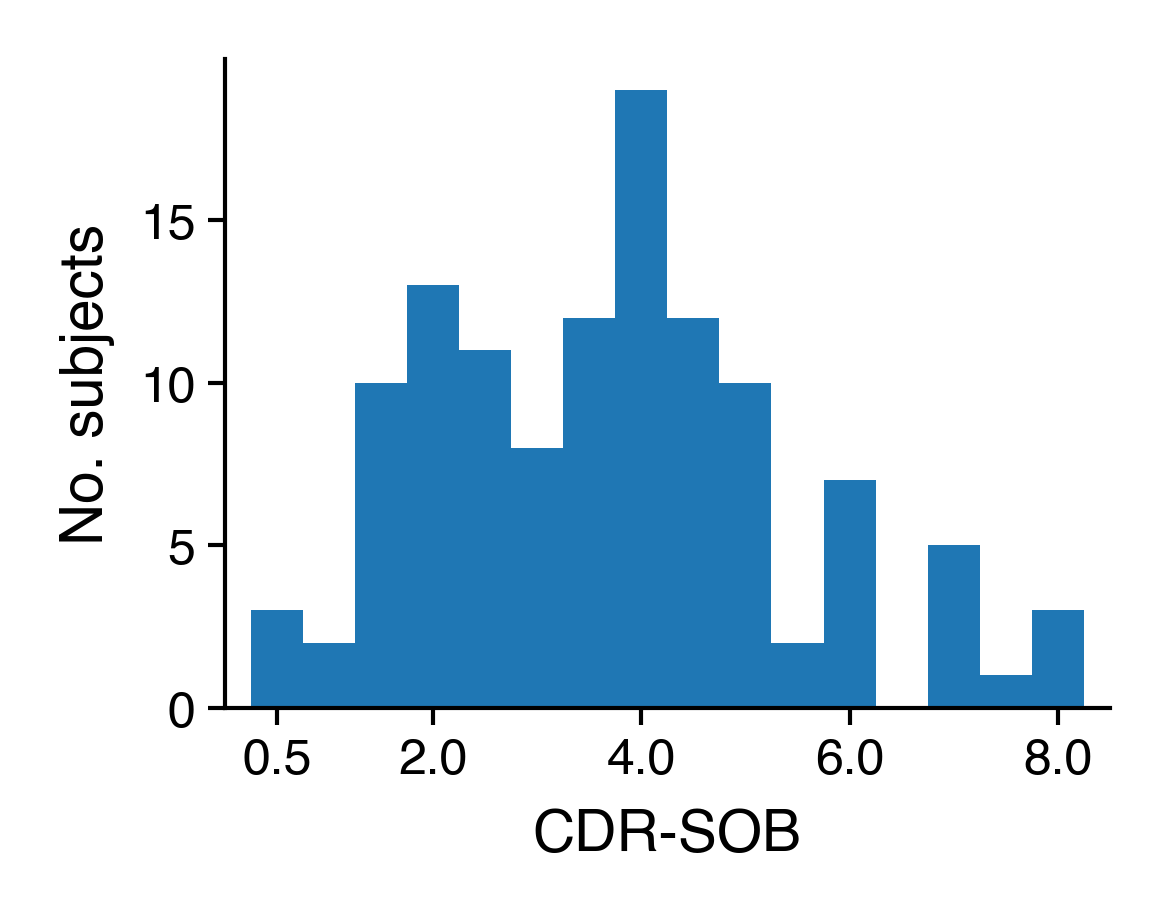

In [14]:
figsize = (colws[1], colws[1]*0.8)
dpi = 600
lw = 0.5
ticklen = 2
tickwidth = 0.5
tickpad = 1.5
labelpad = 3
xlim = [0, 8.5]
xticks = [0.5, 2, 4, 6, 8]
xlab = 'CDR-SOB'
ylab = 'No. subjects'
background_color = "#3F5661"
savefig = 0
overwrite = 1

qry = "(dx=='EOAD') & (pet_visits>1) & (visit==1) & (cdrsob_baseline>=0)"
eoad_cdrs = np.sort(tau_rois_w.query(qry).drop_duplicates('subj')['cdrsob_baseline'].values)
cdr_counts = pd.Series(index=np.linspace(0.5, 8, 16),
                       data=[aop.unique(eoad_cdrs, sort=False).get(x, 0)
                             for x in np.linspace(0.5, 8, 16)])

plt.close('all')
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
ax = np.ravel(ax)

iax = 0
_ax = ax[iax]
_ax.bar(cdr_counts.index, cdr_counts.values, width=0.5)
_ax.spines[["bottom", "left"]].set_linewidth(lw)
_ax.tick_params(labelsize=font["tick"], length=ticklen, width=tickwidth, pad=tickpad)
_ax.set_xlim(xlim)
_ax.set_xticks(xticks)
_ax.set_xlabel(xlab, fontsize=font['label'], labelpad=labelpad)
_ax.set_ylabel(ylab, fontsize=font['label'], labelpad=labelpad)

fig.tight_layout()

print('{} MCI, {} mild dementia'.format(np.sum(eoad_cdrs<=4), np.sum(eoad_cdrs>4)))

In [21]:
# Rank subjects in each diagnostic group by their mean baseline tau-PET W-score across regions.
_tau_rois_w = tau_rois_w.pivot(index=['subj', 'dx', 'visit'], columns=['hemroi'], values='value')[fsrois["hemroi"].tolist()]

subjs_in_order = {}
for grp, df in _tau_rois_w.loc[(slice(None), slice(None), 1),:].mean(axis=1).reset_index().rename(columns={0: 'value'}).groupby('dx'):
    subjs_in_order[grp] = df.sort_values('value')['subj'].tolist()
    
# Re-sort subjects.
_tau_rois_w = _tau_rois_w.reset_index()
_tau_rois_w["subj_order_suvr_all"] = np.nan
for dx in _tau_rois_w['dx'].unique():
    _idx = _tau_rois_w.query("(dx=='{}')".format(dx)).index
    _tau_rois_w.loc[_idx, "subj_order_suvr_all"] = _tau_rois_w.loc[_idx, "subj"].apply(
        lambda x: subjs_in_order[dx].index(x)
    )
_tau_rois_w = _tau_rois_w.sort_values(["dx", "subj_order_suvr_all", "visit"]).reset_index(
    drop=True
)

In [491]:
# # Rank subjects in each diagnostic group by their mean baseline tau-PET W-score across regions.
# _tau_rois_w = tau_rois_w.pivot(index=['subj', 'dx', 'visit'], columns=['hemroi'], values='value')[fsrois["hemroi"].tolist()]#.reset_index()
# _tau_rois_w["subj_order_suvr_all"] = np.nan
# for dx in _tau_rois_w["dx"].unique():
#     _qry = "(dx=='{}')".format(dx)
#     _idx = _tau_rois_w.query(_qry + " & (visit==1)").index
#     subjs_in_order = (
#         _tau_rois_w.loc[_idx, :].sort_values("suvr_all_unweighted")["subj"].tolist()
#     )
#     _idx = _tau_rois_w.query(_qry).index
#     _tau_rois_w.loc[_idx, "subj_order_suvr_all"] = tau_rois_w.loc[_idx, "subj"].apply(
#         lambda x: subjs_in_order.index(x)
#     )

# # Re-sort subjects.
# tau_rois_w = tau_rois_w.sort_values(["dx", "subj_order_suvr_all", "visit"]).reset_index(
#     drop=True
# )

In [22]:
# Make tau-PET W-score matrices (subj x region)
wscore_mats = {}
keep_cols = ["subj_order_suvr_all"] + fsrois["hemroi"].tolist()#cols["suvr"]
# for grp, df in tau_rois_w.groupby(['dx', 'visit']):
#     wscore_mats[grp] = df[keep_cols].values

wscore_mats[("CON", 1)] = (
    _tau_rois_w.query("(dx=='CON') & (visit==1)")
    .sort_values("subj_order_suvr_all")[keep_cols]
    .values
)
wscore_mats[("EOnonAD", 1)] = (
    _tau_rois_w.query("(dx=='EOnonAD') & (visit==1)")
    .sort_values("subj_order_suvr_all")[keep_cols]
    .values
)
wscore_mats[("EOAD", 1)] = (
    _tau_rois_w.query("(dx=='EOAD') & (visit==1)")
    .sort_values("subj_order_suvr_all")[keep_cols]
    .values
)
wscore_mats[("EOAD", 2)] = (
    _tau_rois_w.query("(dx=='EOAD') & (visit==2)")
    .sort_values("subj_order_suvr_all")[keep_cols]
    .values
)
wscore_mats[("EOAD", 3)] = (
    _tau_rois_w.query("(dx=='EOAD') & (visit==3)")
    .sort_values("subj_order_suvr_all")[keep_cols]
    .values
)
wscore_mats[("EOAD", 4)] = (
    _tau_rois_w.query("(dx=='EOAD') & (visit==4)")
    .sort_values("subj_order_suvr_all")[keep_cols]
    .values
)

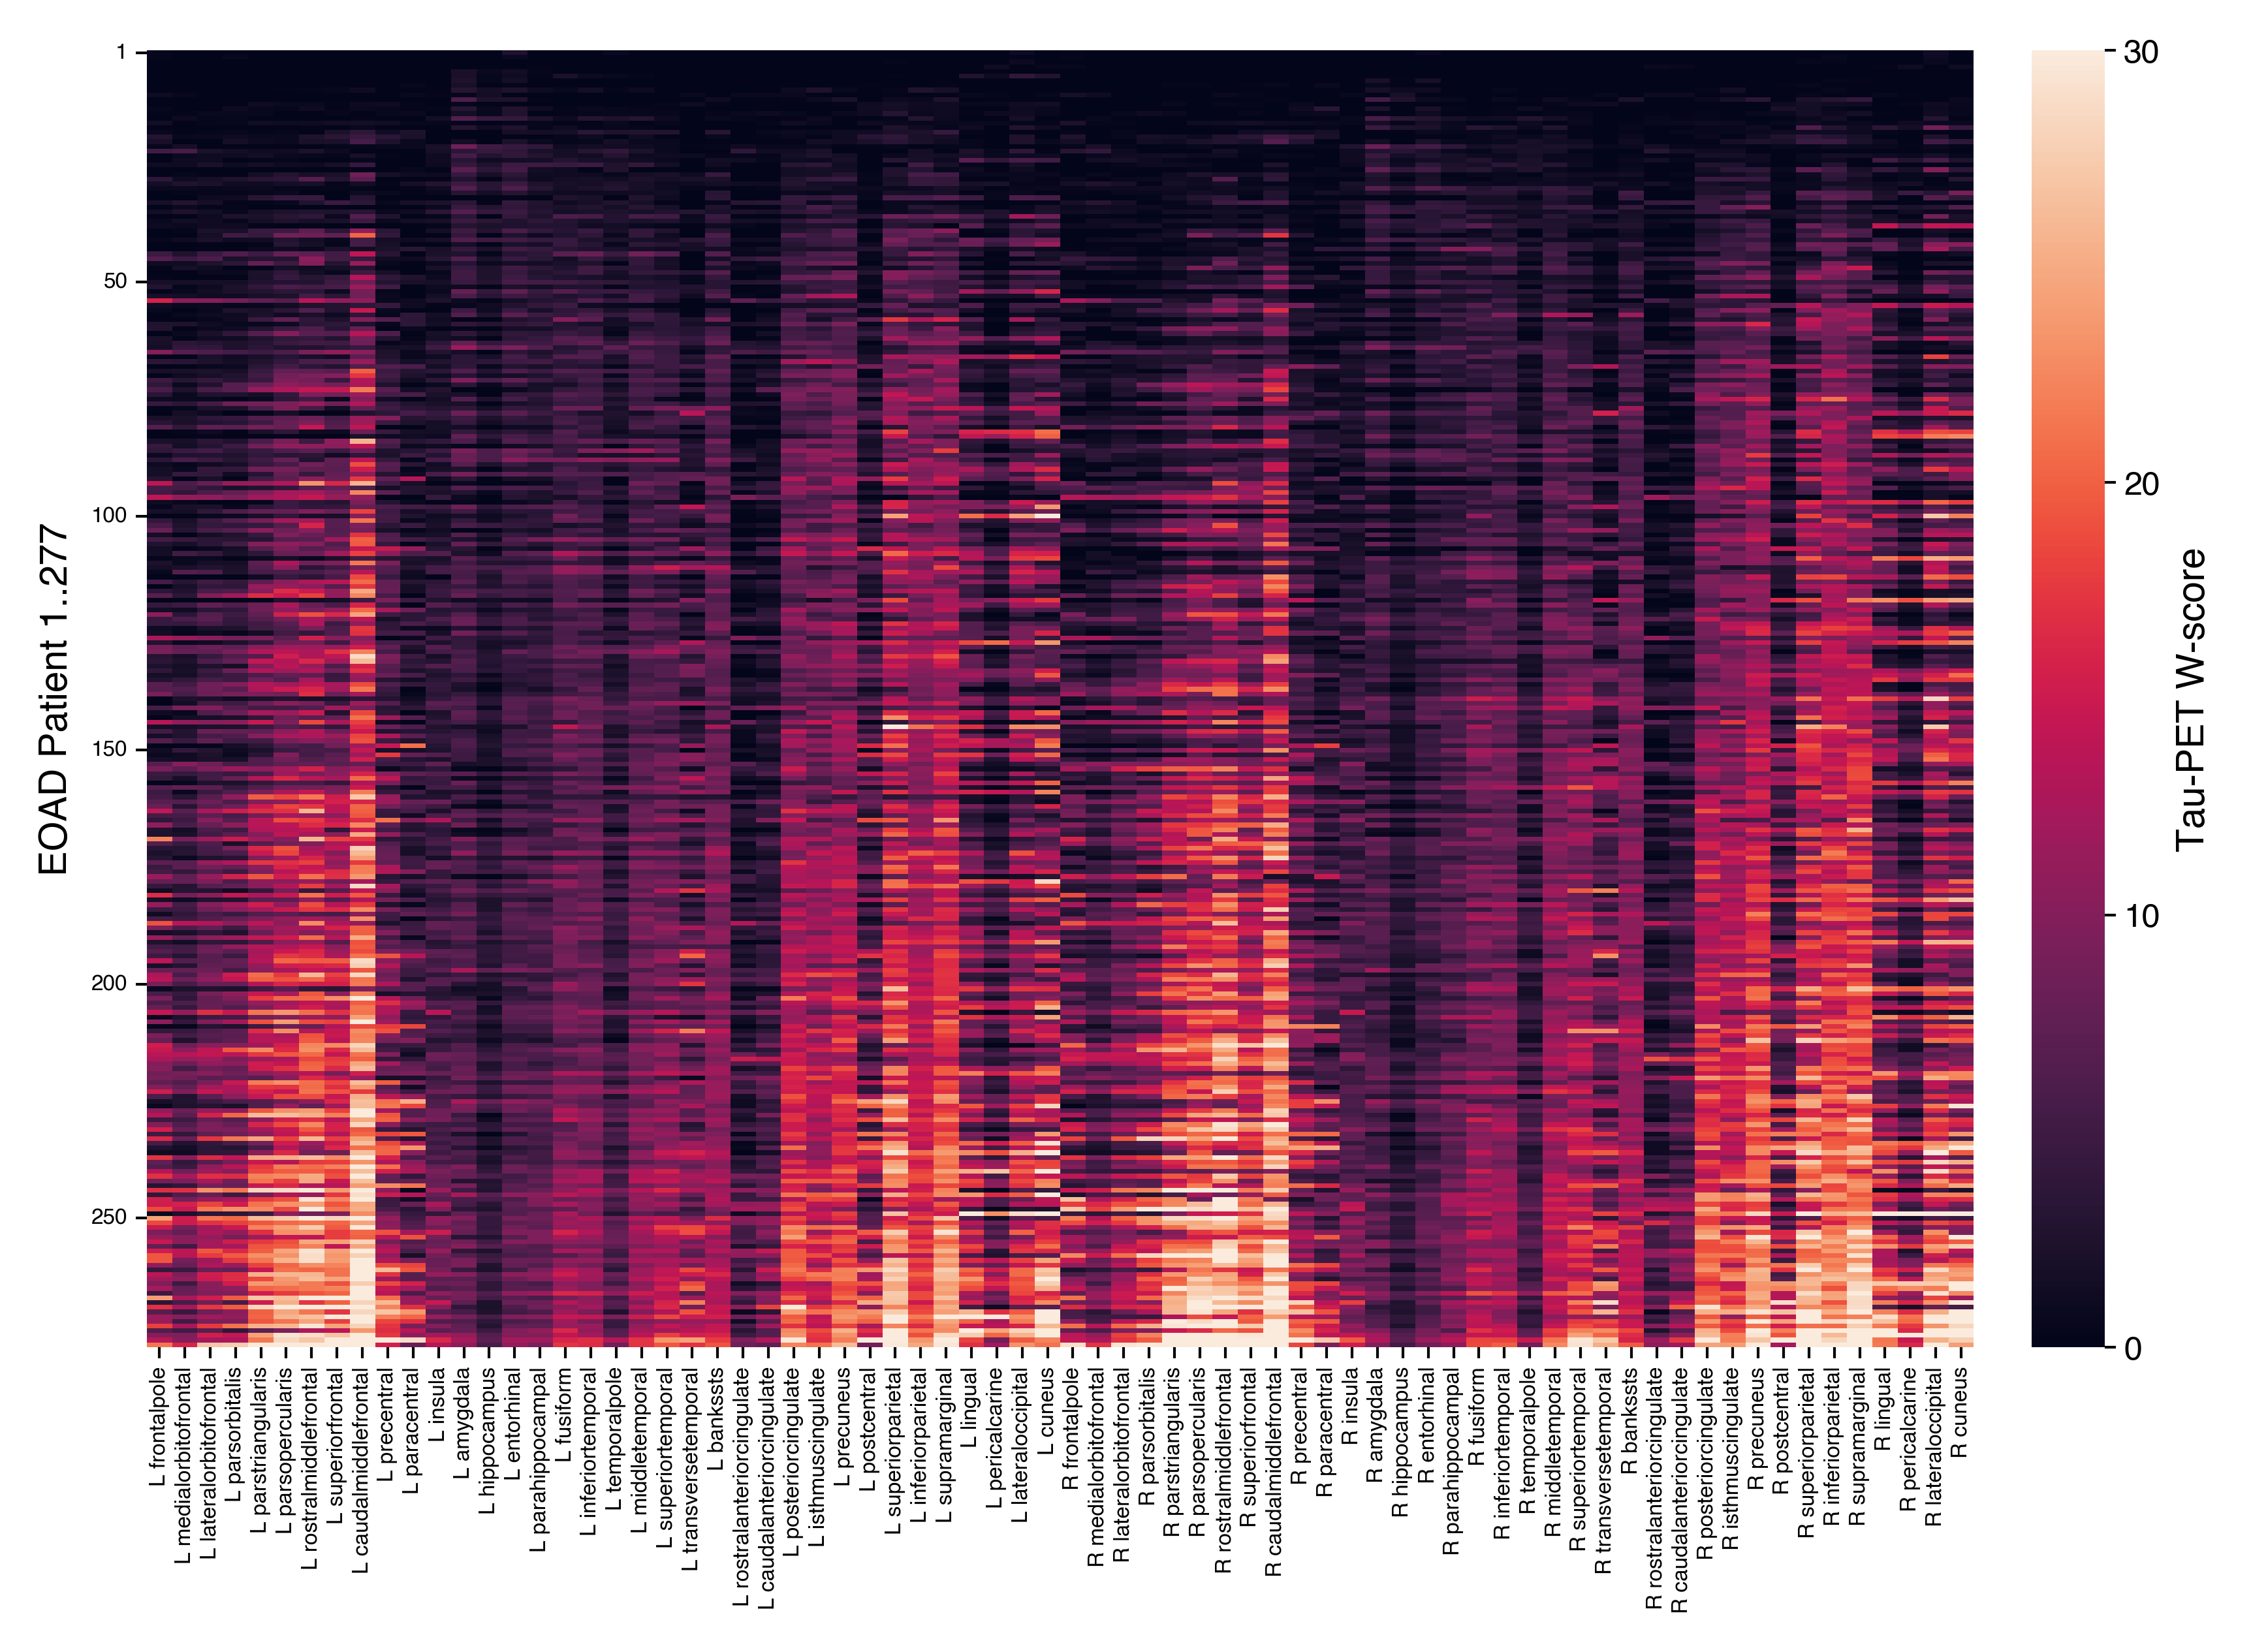

In [23]:
dx = "EOAD"
visit = 1
mat = wscore_mats[(dx, visit)]
mask = None#mat[:, 1:]<2
vmin = 0#2
vmax = 30#48
cbar_ticks = [0, 10, 20, 30]#[2, 12, 24, 36, 48]
cmap = "rocket"
cbar_label = "Tau-PET W-score"

# visit = "2 - 1"
# mat = wscore_mats[(dx, 2)] - wscore_mats[(dx, 1)]
# scaling_factor = (
#     tau_rois_w.query("(dx=='EOAD') & (pet_visits>1) & (visit==2)").sort_values(
#         "subj_order_suvr_all"
#     )["days_from_baseline_pet"]
#     / 365
# ).values
# mat /= np.expand_dims(scaling_factor, axis=-1)  # change/year
# mask = None
# vmin = -12
# vmax = 12
# cbar_ticks = [-12, -6, 0, 6, 12]
# cmap = "RdBu_r"
# cbar_label = "FTP W-Score ($\Delta$/yr)"

colws = {1: 2.05, 2: 3.125, 3: 6.45}
grid_shp = [50, 75]
figsize = (colws[3], colws[3] * (grid_shp[0] / grid_shp[1]))
dpi = 600
ticklen = 2
tickwidth = 0.5
tickpad = 1.5
labelpad = 3
nsubjs = mat.shape[0]
# roi_ticks_major = np.where(
#     np.concatenate(
#         ([True], fsrois["lobe"].values[:-1] != fsrois["lobe"].values[1:], [True])
#     )
# )[0]
# roi_ticks_minor = aop.rolling_func(roi_ticks_major, np.mean, 2)
# roi_tick_labs = (
#     fsrois[["hem", "lobe"]]
#     .drop_duplicates()
#     .apply(lambda x: "{} {}".format(x["hem"], x["lobe"].capitalize()), axis=1)
#     .values
# )
xticks = np.arange(len(fsrois["hemroi"])) + 0.5
xticklabs = [x.replace('_', ' ') for x in fsrois["hemroi"].tolist()]
yticks = np.array([1, 50, 100, 150, 200, 250]) - 0.5
yticklabs = np.array([1, 50, 100, 150, 200, 250])
fig_title = "Visit {}".format(visit)
background_color = "#3F5661"
savefig = 0
overwrite = 1
# ---------------------

plt.close("all")
fig = plt.figure(figsize=figsize, dpi=dpi)
ax = [
    plt.subplot2grid(grid_shp, (0, 0), rowspan=50, colspan=70),
    plt.subplot2grid(grid_shp, (0, 72), rowspan=50, colspan=3),
]

iax = 0
_ax = ax[iax]
_ax = sns.heatmap(
    mat[:, 1:],
    mask=mask,
    vmin=vmin,
    vmax=vmax,
    ax=_ax,
    cbar=True,
    cbar_ax=ax[iax + 1],
    cmap=cmap,
)

cbar = _ax.collections[0].colorbar
cbar.ax.tick_params(
    labelsize=font["tick"], length=ticklen, width=tickwidth, pad=tickpad
)
cbar.set_ticks(cbar_ticks)
cbar.set_ticklabels(cbar_ticks)
if cbar_label is not None:
    cbar.set_label(cbar_label, fontsize=font["label"], labelpad=labelpad)
_ax.set_facecolor(background_color)
# _ax.invert_yaxis()
# _ax.tick_params(
#     which="major", labelsize=font["tick"], length=ticklen, width=tickwidth, pad=tickpad
# )
# _ax.tick_params(
#     which="minor", labelsize=font["tick"] - 2, length=0, pad=tickpad * 1.5, rotation=90
# )
# _ax.set_xticks(roi_ticks_major)
# _ax.set_xticks(roi_ticks_minor, minor=True)
# _ax.set_xticklabels(roi_tick_labs, minor=True)
_ax.tick_params(
    axis="x", labelsize=font["tick"]-2, length=ticklen, width=tickwidth, pad=tickpad, rotation=90
)
_ax.tick_params(
    axis="y", labelsize=font["tick"]-2, length=ticklen, width=tickwidth, pad=tickpad
)
_ax.set_xticks(xticks)
_ax.set_xticklabels(xticklabs)
_ax.set_yticks(yticks)
_ax.set_yticklabels(yticklabs)
_ax.set_ylabel(
    "EOAD Patient 1..{}".format(nsubjs), fontsize=font["label"], labelpad=labelpad
)
# _ax.set_title(fig_title, fontsize=font["title"])

if savefig:
    filename = op.join(
        fig_dir,
        "FTP_ROI_W-scores_{}_Visit{}_{}subjs2.png".format(
            dx, str(visit).replace(" ", ""), nsubjs
        ),
    )
    if overwrite or not op.exists(filename):
        fig.savefig(filename, dpi=dpi, bbox_inches="tight", pad_inches=0)
        fig.savefig(filename.replace(".png", ".pdf"), bbox_inches="tight", pad_inches=0)
        print("Saved {}".format(filename))

Saved /Users/dschonhaut/box/projects/leads_tau_spread/figs/FTP_ROI_W-scores_EOAD_Visit1_277subjsT.png


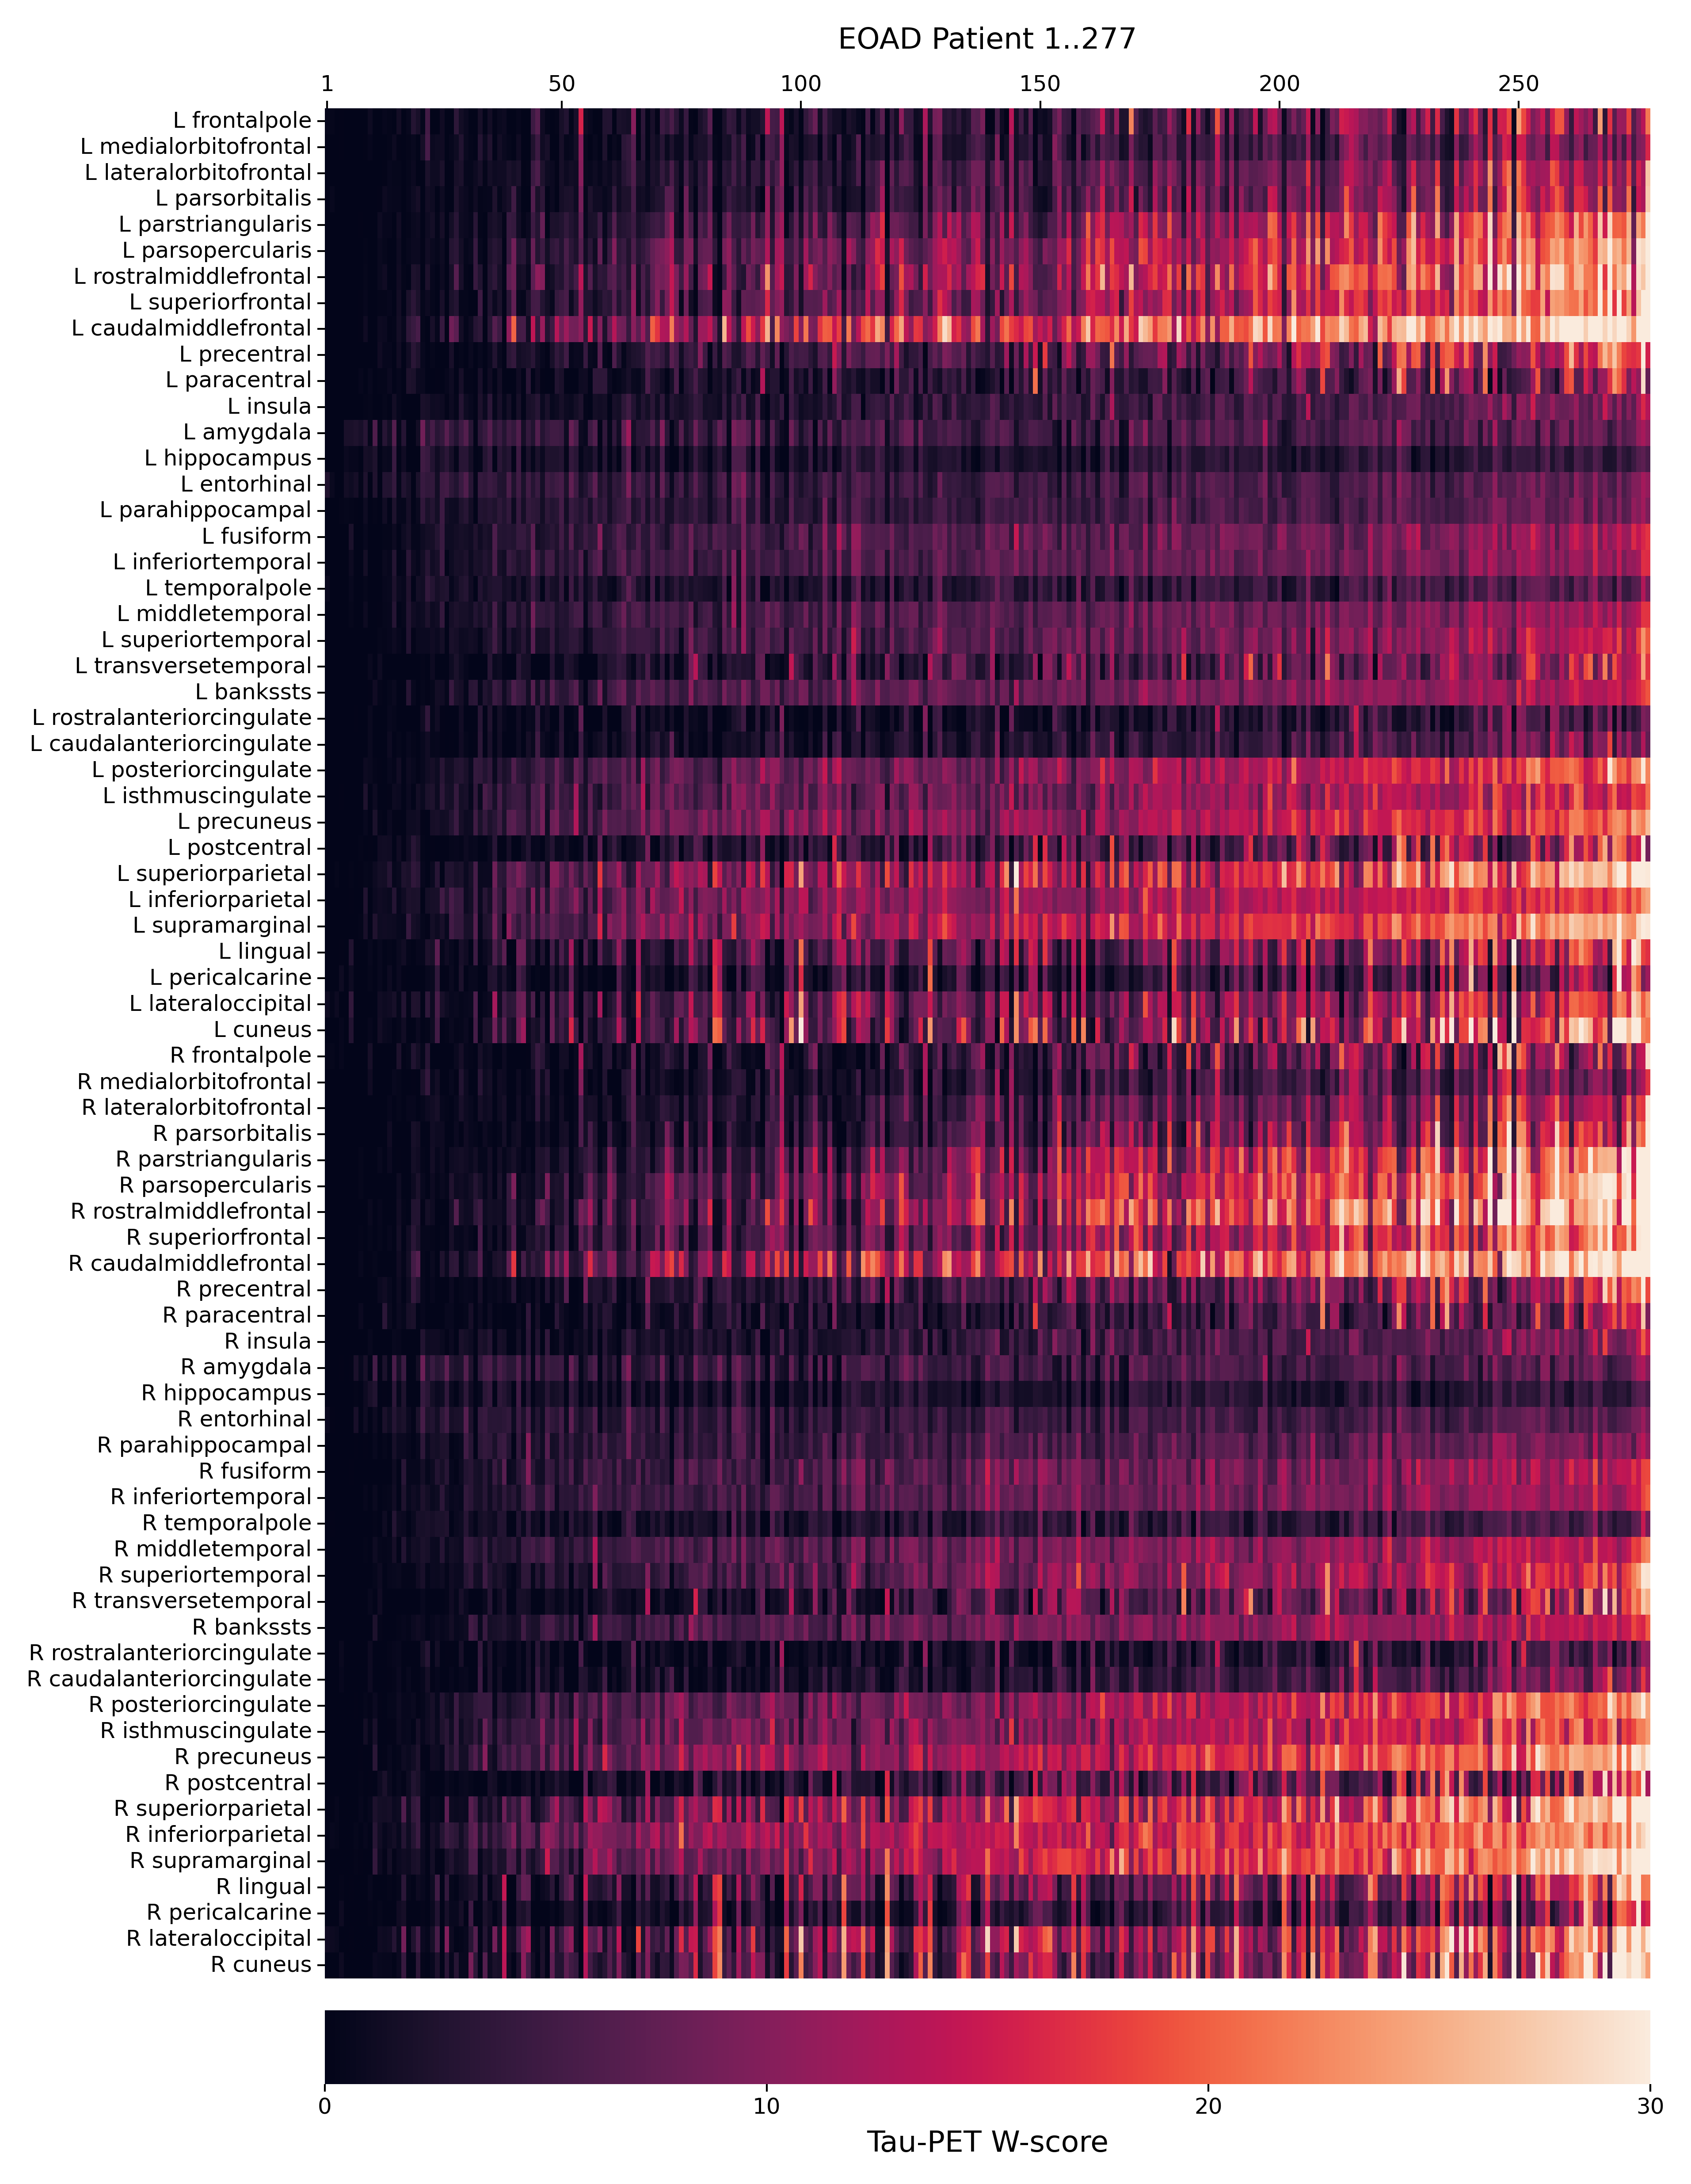

In [555]:
dx = "EOAD"
visit = 1
mat = wscore_mats[(dx, visit)]
mask = None#mat[:, 1:]<2
vmin = 0#2
vmax = 30#48
cbar_ticks = [0, 10, 20, 30]#[2, 12, 24, 36, 48]
cmap = "rocket"
cbar_label = "Tau-PET W-score"

# visit = "2 - 1"
# mat = wscore_mats[(dx, 2)] - wscore_mats[(dx, 1)]
# scaling_factor = (
#     tau_rois_w.query("(dx=='EOAD') & (pet_visits>1) & (visit==2)").sort_values(
#         "subj_order_suvr_all"
#     )["days_from_baseline_pet"]
#     / 365
# ).values
# mat /= np.expand_dims(scaling_factor, axis=-1)  # change/year
# mask = None
# vmin = -12
# vmax = 12
# cbar_ticks = [-12, -6, 0, 6, 12]
# cmap = "RdBu_r"
# cbar_label = "FTP W-Score ($\Delta$/yr)"

colws = {1: 2.05, 2: 3.125, 3: 6.45}
grid_shp = [75, 50]
figsize = (colws[3], colws[3]*(grid_shp[0] / grid_shp[1]))
dpi = 600
ticklen = 2
tickwidth = 0.5
tickpad = 1.5
labelpad = 5
nsubjs = mat.shape[0]
# roi_ticks_major = np.where(
#     np.concatenate(
#         ([True], fsrois["lobe"].values[:-1] != fsrois["lobe"].values[1:], [True])
#     )
# )[0]
# roi_ticks_minor = aop.rolling_func(roi_ticks_major, np.mean, 2)
# roi_tick_labs = (
#     fsrois[["hem", "lobe"]]
#     .drop_duplicates()
#     .apply(lambda x: "{} {}".format(x["hem"], x["lobe"].capitalize()), axis=1)
#     .values
# )
yticks = np.arange(len(fsrois["hemroi"])) + 0.5
yticklabs = [x.replace('_', ' ') for x in fsrois["hemroi"].tolist()]
xticks = np.array([1, 50, 100, 150, 200, 250]) - 0.5
xticklabs = np.array([1, 50, 100, 150, 200, 250])
fig_title = "Visit {}".format(visit)
background_color = "#3F5661"
savefig = 1
overwrite = 1
# ---------------------

plt.close("all")
fig = plt.figure(figsize=figsize, dpi=dpi)
ax = [
    plt.subplot2grid(grid_shp, (0, 0), rowspan=71, colspan=50),
    plt.subplot2grid(grid_shp, (72, 0), rowspan=3, colspan=50),
]

iax = 0
_ax = ax[iax]
_ax = sns.heatmap(
    mat[:, 1:].T,
    mask=mask,
    vmin=vmin,
    vmax=vmax,
    ax=_ax,
    cbar=True,
    cbar_ax=ax[iax + 1],
    cmap=cmap,
    cbar_kws={"orientation": "horizontal"}
)

cbar = _ax.collections[0].colorbar
cbar.ax.tick_params(
    labelsize=font["tick"], length=ticklen, width=tickwidth, pad=tickpad
)
cbar.set_ticks(cbar_ticks)
cbar.set_ticklabels(cbar_ticks)
if cbar_label is not None:
    cbar.set_label(cbar_label, fontsize=font["label"]+1, labelpad=labelpad-2)
_ax.set_facecolor(background_color)
# _ax.invert_yaxis()
# _ax.tick_params(
#     which="major", labelsize=font["tick"], length=ticklen, width=tickwidth, pad=tickpad
# )
# _ax.tick_params(
#     which="minor", labelsize=font["tick"] - 2, length=0, pad=tickpad * 1.5, rotation=90
# )
# _ax.set_xticks(roi_ticks_major)
# _ax.set_xticks(roi_ticks_minor, minor=True)
# _ax.set_xticklabels(roi_tick_labs, minor=True)
_ax.tick_params(
    axis="x", labelsize=font["tick"], length=ticklen, width=tickwidth, pad=tickpad, rotation=0
)
_ax.tick_params(
    axis="y", labelsize=font["tick"], length=ticklen, width=tickwidth, pad=tickpad, rotation=0
)
_ax.xaxis.tick_top()
_ax.xaxis.set_label_position('top')

_ax.set_xticks(xticks)
_ax.set_xticklabels(xticklabs)
_ax.set_yticks(yticks)
_ax.set_yticklabels(yticklabs)
_ax.set_xlabel(
    "EOAD Patient 1..{}".format(nsubjs), fontsize=font["label"]+1, labelpad=labelpad+2
)
# _ax.set_title(fig_title, fontsize=font["title"])

if savefig:
    filename = op.join(
        fig_dir,
        "FTP_ROI_W-scores_{}_Visit{}_{}subjsT.png".format(
            dx, str(visit).replace(" ", ""), nsubjs
        ),
    )
    if overwrite or not op.exists(filename):
        fig.savefig(filename, dpi=dpi, bbox_inches="tight", pad_inches=0.1)
        fig.savefig(filename.replace(".png", ".pdf"), bbox_inches="tight", pad_inches=0)
        print("Saved {}".format(filename))

In [25]:
w_base = (
    tau_rois_w.query("(dx=='EOAD') & (pet_visits>1) & (visit==1)")
    .set_index("subj")
    [cols["suvr"]]
)

w_diff = (
    tau_rois_w.query("(dx=='EOAD') & (pet_visits>1) & (visit==2)")
    .set_index("subj")
    [cols["suvr"]]
) - (
    tau_rois_w.query("(dx=='EOAD') & (pet_visits>1) & (visit==1)")
    .set_index("subj")
    [cols["suvr"]]
)
scaling_factor = (
    tau_rois_w.query("(dx=='EOAD') & (pet_visits>1) & (visit==2)")
    .set_index("subj")
    ["years_from_baseline_pet"]
)
w_diff /= np.expand_dims(scaling_factor, axis=-1)  # change/year

# Rearrange the dataframe.
fsrois["fsroi"] = fsrois.apply(
    lambda x: "{}_{}_suvr".format(x["hem"].lower(), x["region"]), axis=1
)
fsrois["hemroi"] = fsrois.apply(lambda x: "{}_{}".format(x["hem"], x["region"]), axis=1)
w_base = pd.merge(
    w_base.stack().reset_index().rename(columns={"level_1": "fsroi", 0: "value"}),
    fsrois[["fsroi", "hem", "region", "hemroi", "lobe"]],
    how="left",
    on="fsroi",
)[["subj", "hem", "region", "hemroi", "lobe", "value"]]
w_diff = pd.merge(
    w_diff.stack().reset_index().rename(columns={"level_1": "fsroi", 0: "value"}),
    fsrois[["fsroi", "hem", "region", "hemroi", "lobe"]],
    how="left",
    on="fsroi",
)[["subj", "hem", "region", "hemroi", "lobe", "value"]]

KeyError: "None of [Index(['l_frontalpole_suvr', 'l_medialorbitofrontal_suvr',\n       'l_lateralorbitofrontal_suvr', 'l_parsorbitalis_suvr',\n       'l_parstriangularis_suvr', 'l_parsopercularis_suvr',\n       'l_rostralmiddlefrontal_suvr', 'l_superiorfrontal_suvr',\n       'l_caudalmiddlefrontal_suvr', 'l_precentral_suvr', 'l_paracentral_suvr',\n       'l_insula_suvr', 'l_amygdala_suvr', 'l_hippocampus_suvr',\n       'l_entorhinal_suvr', 'l_parahippocampal_suvr', 'l_fusiform_suvr',\n       'l_inferiortemporal_suvr', 'l_temporalpole_suvr',\n       'l_middletemporal_suvr', 'l_superiortemporal_suvr',\n       'l_transversetemporal_suvr', 'l_bankssts_suvr',\n       'l_rostralanteriorcingulate_suvr', 'l_caudalanteriorcingulate_suvr',\n       'l_posteriorcingulate_suvr', 'l_isthmuscingulate_suvr',\n       'l_precuneus_suvr', 'l_postcentral_suvr', 'l_superiorparietal_suvr',\n       'l_inferiorparietal_suvr', 'l_supramarginal_suvr', 'l_lingual_suvr',\n       'l_pericalcarine_suvr', 'l_lateraloccipital_suvr', 'l_cuneus_suvr',\n       'r_frontalpole_suvr', 'r_medialorbitofrontal_suvr',\n       'r_lateralorbitofrontal_suvr', 'r_parsorbitalis_suvr',\n       'r_parstriangularis_suvr', 'r_parsopercularis_suvr',\n       'r_rostralmiddlefrontal_suvr', 'r_superiorfrontal_suvr',\n       'r_caudalmiddlefrontal_suvr', 'r_precentral_suvr', 'r_paracentral_suvr',\n       'r_insula_suvr', 'r_amygdala_suvr', 'r_hippocampus_suvr',\n       'r_entorhinal_suvr', 'r_parahippocampal_suvr', 'r_fusiform_suvr',\n       'r_inferiortemporal_suvr', 'r_temporalpole_suvr',\n       'r_middletemporal_suvr', 'r_superiortemporal_suvr',\n       'r_transversetemporal_suvr', 'r_bankssts_suvr',\n       'r_rostralanteriorcingulate_suvr', 'r_caudalanteriorcingulate_suvr',\n       'r_posteriorcingulate_suvr', 'r_isthmuscingulate_suvr',\n       'r_precuneus_suvr', 'r_postcentral_suvr', 'r_superiorparietal_suvr',\n       'r_inferiorparietal_suvr', 'r_supramarginal_suvr', 'r_lingual_suvr',\n       'r_pericalcarine_suvr', 'r_lateraloccipital_suvr', 'r_cuneus_suvr'],\n      dtype='object')] are in the [columns]"

In [245]:
base_roi_order = (
    w_base.groupby(["region"])["value"]
    .apply(lambda x: stats.ttest_1samp(x, popmean=0)[1])
    .sort_values()
    .index.tolist()
)
diff_roi_order = (
    w_diff.groupby(["region"])["value"]
    .apply(lambda x: stats.ttest_1samp(x, popmean=0)[1])
    .sort_values()
    .index.tolist()
)

In [218]:
base_roi_order = (
    w_base.groupby(["region"])["value"]
    .apply(np.median)
    .sort_values(ascending=False)
    .index.tolist()
)
diff_roi_order = (
    w_diff.groupby(["region"])["value"]
    .apply(np.median)
    .sort_values(ascending=False)
    .index.tolist()
)

NameError: name 'w_base' is not defined

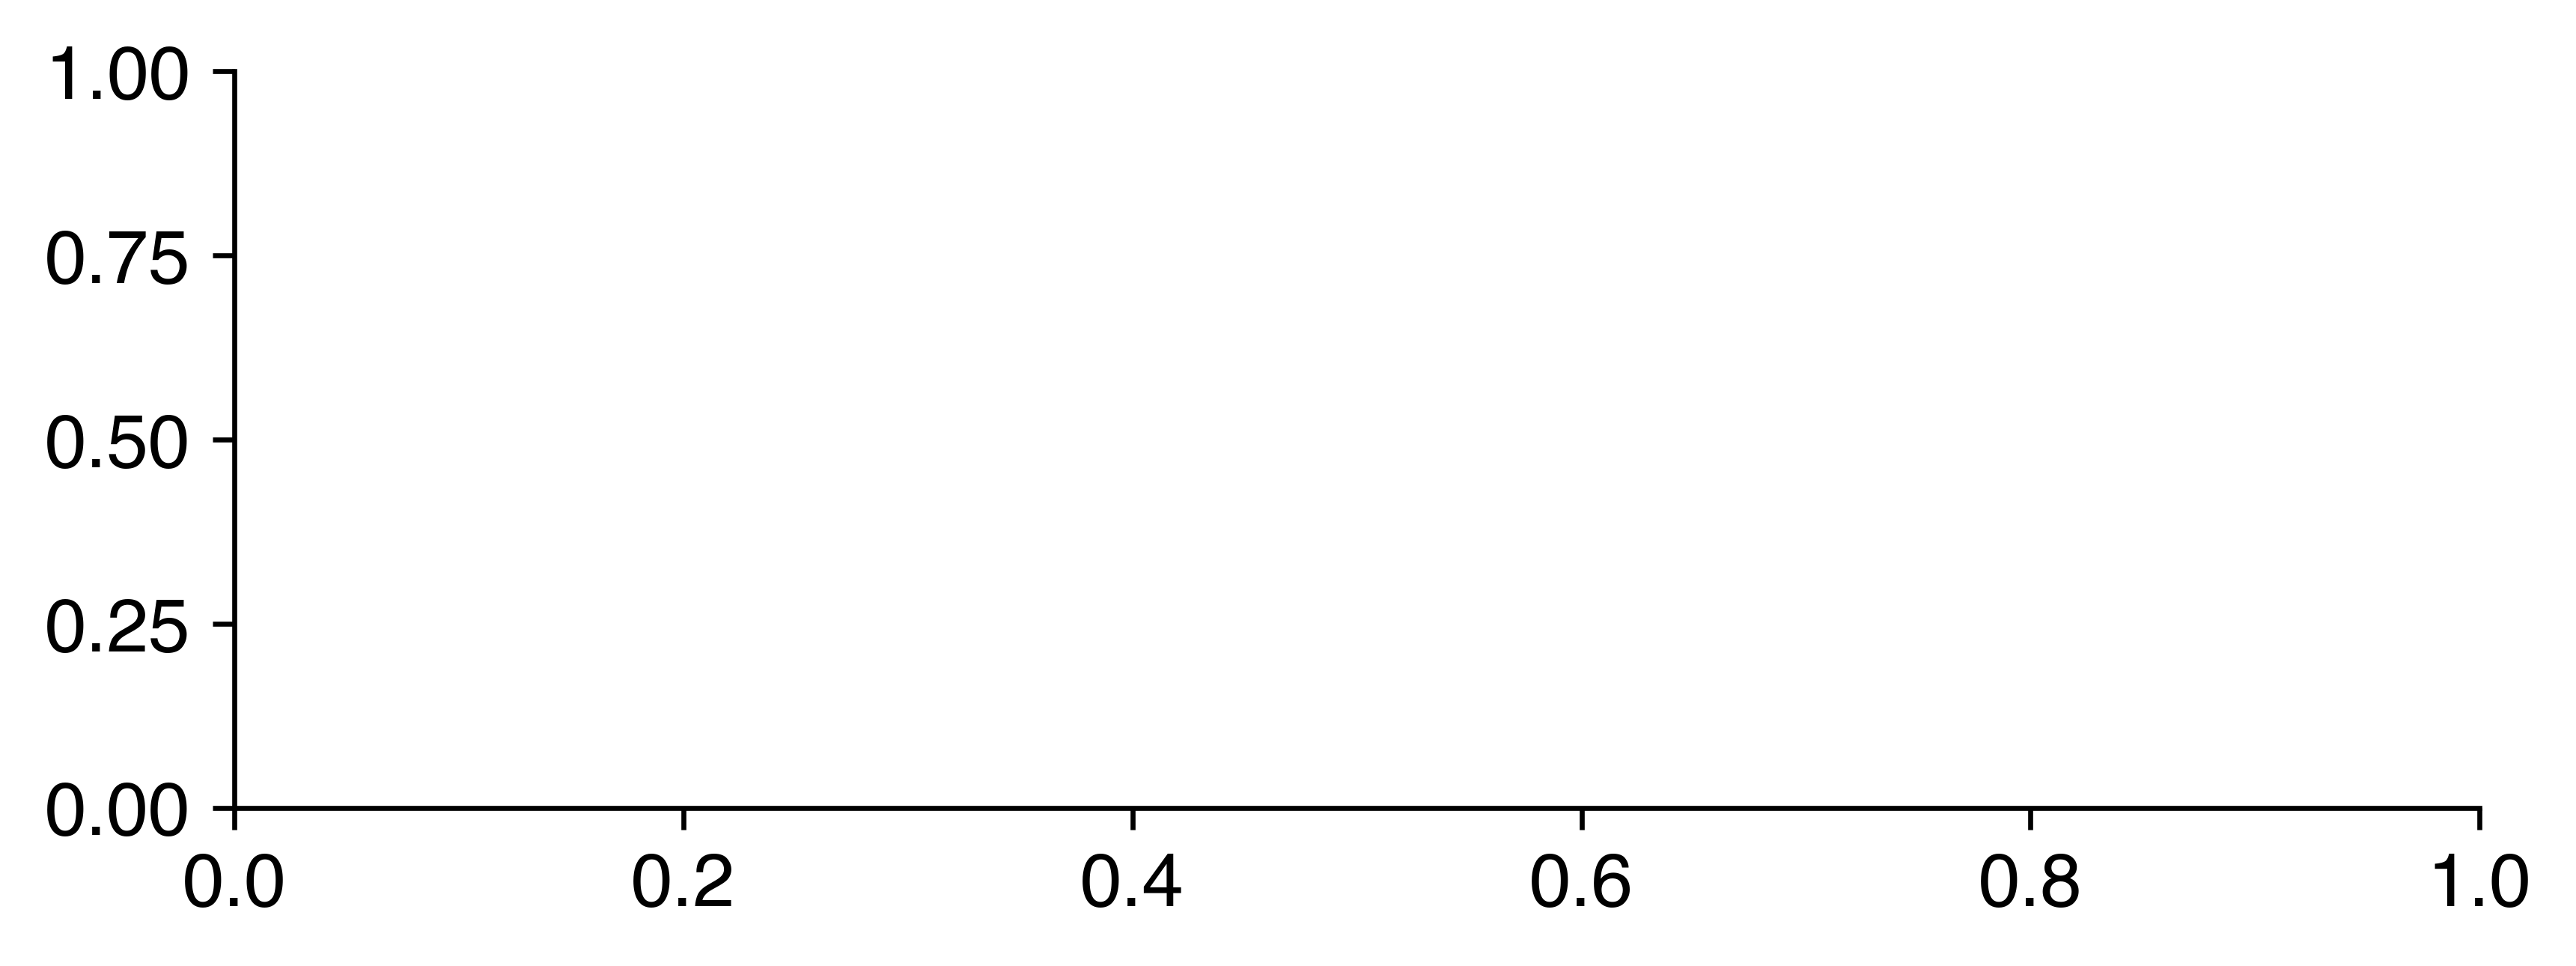

In [15]:
figsize = (colws[3], colws[3] * 0.33)
dpi = 600
alpha = 0.5
lw = 0.5
ylim = [-6, 48]
yticks = [0, 12, 24, 36, 48]
ticklen = 3
tickwidth = 0.5
tickpad = 1.5
labelpad = 3
# ------------------

plt.close("all")
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
ax = np.ravel(ax)

iax = 0
_ax = iax
# _ax = sns.barplot(data=w_base, x='region', y='value', estimator='median', order=base_roi_order, errorbar='ci', color='#B7C6CF')
_ax = sns.violinplot(
    data=w_base,
    x="region",
    y="value",
    estimator="median",
    order=base_roi_order,
    errorbar="ci",
    color="#B7C6CF",
    cut=0,
    linewidth=lw,
    inner="quartile",
)
_ax.axhline(0, color="k", zorder=0, linewidth=lw)
_ax.spines[["bottom", "left"]].set_linewidth(lw)
_ax.tick_params(
    axis="x",
    labelsize=font["tick"],
    length=ticklen,
    width=tickwidth,
    pad=tickpad,
    rotation=90,
)
_ax.tick_params(
    axis="y", labelsize=font["tick"], length=ticklen, width=tickwidth, pad=tickpad
)
_ax.set_ylim(ylim)
_ax.set_yticks(yticks)
_ax.set_xlabel("")
_ax.set_ylabel("FTP W-Score", fontsize=font["label"], labelpad=labelpad)

<>:29: DeprecationWarning: invalid escape sequence '\D'
<>:29: DeprecationWarning: invalid escape sequence '\D'
/var/folders/c6/3jkgtnm96jqdyqv_gqr__hy00000gp/T/ipykernel_99800/673245557.py:29: DeprecationWarning: invalid escape sequence '\D'
  _ax.set_ylabel('$\Delta$ FTP W-Score', fontsize=font['label'], labelpad=labelpad)


Text(0, 0.5, '$\\Delta$ FTP W-Score')

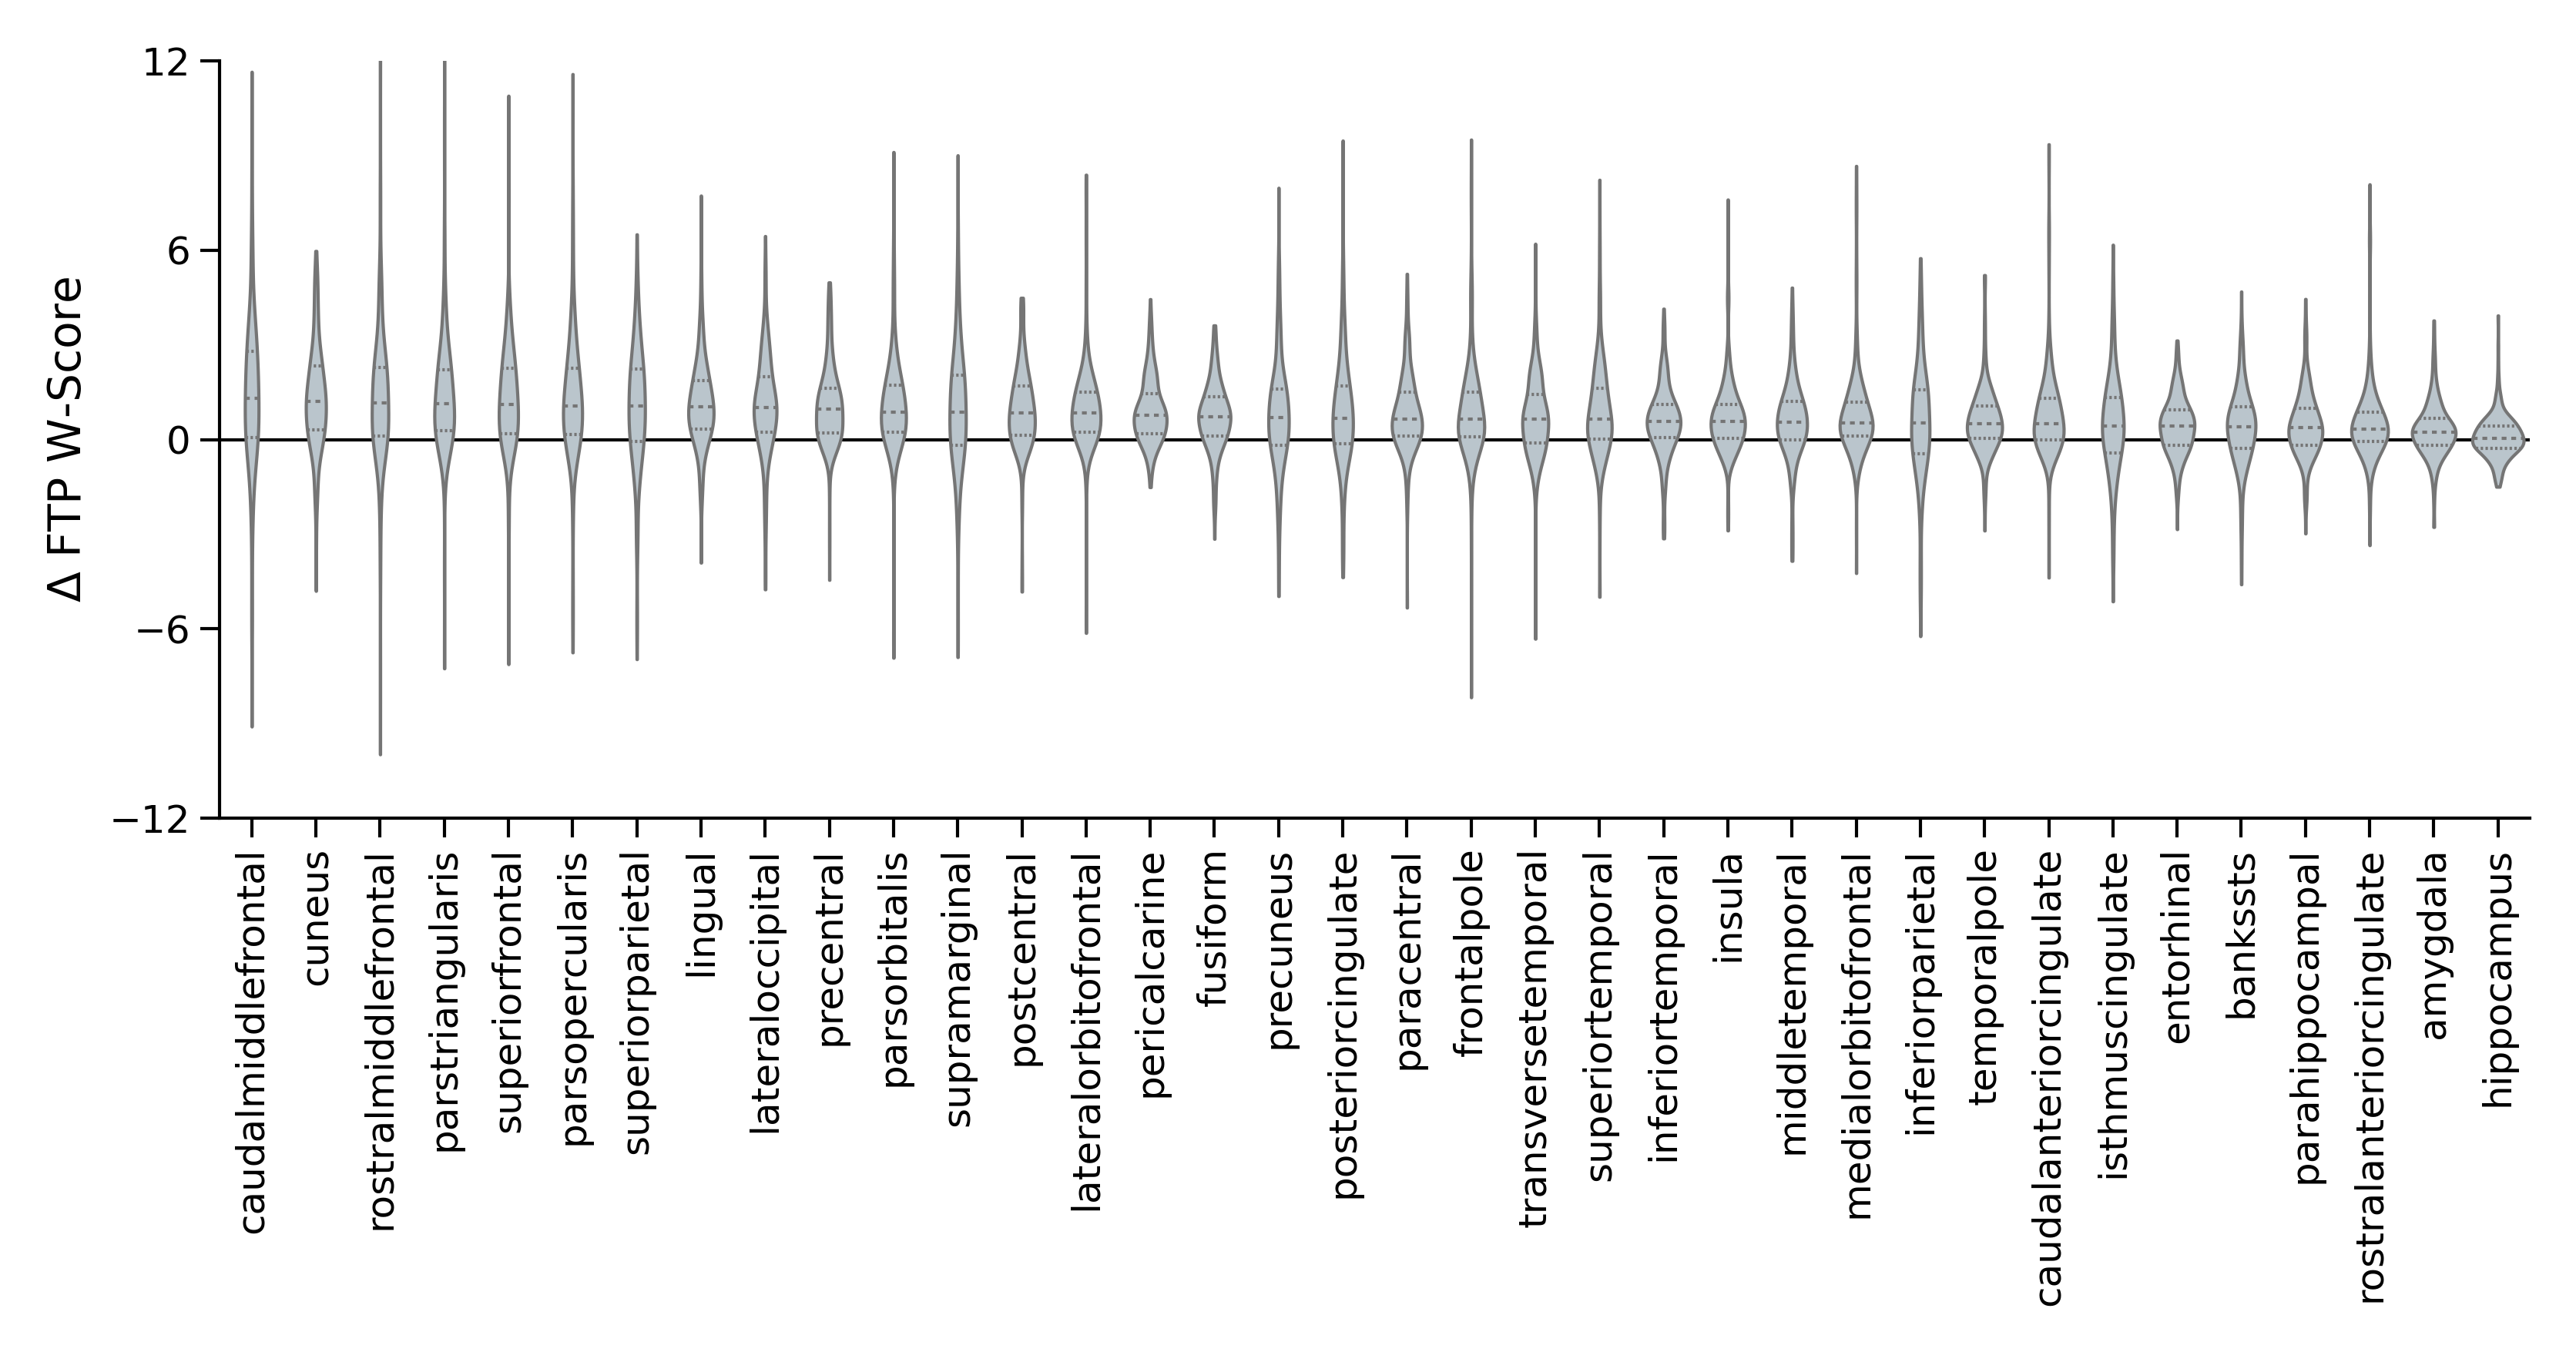

In [237]:
figsize = (colws[3], colws[3] * 0.33)
dpi = 600
alpha = 0.5
lw = 0.5
ylim = [-12, 12]
yticks = [-12, -6, 0, 6, 12]
ticklen = 3
tickwidth = 0.5
tickpad = 1.5
labelpad = 3
# ------------------

plt.close("all")
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
ax = np.ravel(ax)

iax = 0
_ax = iax
# _ax = sns.barplot(data=w_diff, x='region', y='value', estimator='median', order=diff_roi_order, errorbar='ci', color='#B7C6CF')
_ax = sns.violinplot(
    data=w_diff,
    x="region",
    y="value",
    estimator="median",
    order=diff_roi_order,
    errorbar="ci",
    color="#B7C6CF",
    cut=0,
    linewidth=lw,
    inner="quartile",
    dodge=True,
)
_ax.axhline(0, color="k", zorder=0, linewidth=lw)
_ax.spines[["bottom", "left"]].set_linewidth(lw)
_ax.tick_params(
    axis="x",
    labelsize=font["tick"],
    length=ticklen,
    width=tickwidth,
    pad=tickpad,
    rotation=90,
)
_ax.tick_params(
    axis="y", labelsize=font["tick"], length=ticklen, width=tickwidth, pad=tickpad
)
_ax.set_ylim(ylim)
_ax.set_yticks(yticks)
_ax.set_xlabel("")
_ax.set_ylabel("$\Delta$ FTP W-Score", fontsize=font["label"], labelpad=labelpad)

# Plot ROI regression betas to Freesurfer Nifti

In [5]:
# Load FreeSurfer ROI labels.
coef_eoad_con_bline = pd.read_csv(
    op.join(proj_dir, "data", "ssheets", "coef_eoad_con_bline.csv")
)
coef_eoad_time = pd.read_csv(
    op.join(proj_dir, "data", "ssheets", "coef_eoad_time_all.csv")
)
merged_df = pd.read_csv(
    op.join(proj_dir, "data", "ssheets", "merged_df_all.csv")
)
coef_eoad_time_cdrgt4 = pd.read_csv(
    op.join(proj_dir, "data", "ssheets", "coef_eoad_time_cdrgt4.csv")
)

coef_eoad_con_bline = pd.merge(fsrois.loc[:, ['hemroi', 'hem', 'label']], coef_eoad_con_bline, on='hemroi')
coef_eoad_time = pd.merge(fsrois.loc[:, ['hemroi', 'hem', 'label']], coef_eoad_time, on='hemroi')
merged_df = pd.merge(fsrois.loc[:, ['hemroi', 'hem', 'label']], merged_df, on='hemroi')
coef_eoad_time_cdrgt4 = pd.merge(fsrois.loc[:, ['hemroi', 'hem', 'label']], coef_eoad_time_cdrgt4, on='hemroi')

In [14]:
# Load the Freesurfer template
aparc_filepath = op.join(proj_dir, "data", "template_rois", "aparcaseg_DK_1mm.nii.gz")
aparc_img, aparc_dat = nops.load_nii(aparc_filepath, dtype=int, conv_nan=None)

In [29]:
coef_eoad_time_cdrgt4.head()

,hemroi,hem,label,nrow,coef,est,sem,ci2.5,ci97.5,df,tval,pval,pval_fdr,sig_fdr
0,L_frontalpole,L,1032,369,(Intercept),4.323599,0.507471,3.340210,5.256377,210.846689,8.519900,3.047453e-15,1.438797e-14,True
1,L_frontalpole,L,1032,369,years_from_baseline_pet,0.695644,0.115521,0.463371,0.922072,167.165315,6.021812,1.062947e-08,2.757917e-08,True
2,L_frontalpole,L,1032,369,cdrsob_gt4TRUE,3.526323,0.864521,1.784059,5.027126,210.962083,4.078931,6.413338e-05,9.670374e-05,True
3,L_frontalpole,L,1032,369,years_from_baseline_pet:cdrsob_gt4TRUE,0.519033,0.205296,0.107257,0.934240,167.133166,2.528223,1.239107e-02,1.551578e-02,True
4,L_medialorbitofrontal,L,1014,369,(Intercept),3.163719,0.351187,2.486953,3.847818,213.841164,9.008641,1.180058e-16,6.068870e-16,True


In [30]:
# FDR-correct p-values.
alpha = 0.05

coef_eoad_con_bline = coef_eoad_con_bline.query("(coef=='dxEOAD')").reset_index(drop=True)
coef_eoad_con_bline['pval_fdr'] = sm.stats.multipletests(coef_eoad_con_bline['pval'], method='fdr_bh')[1]
coef_eoad_con_bline['sig_fdr'] = coef_eoad_con_bline['pval_fdr'] < alpha

coef_eoad_time['pval_fdr'] = np.nan
coef_eoad_time['sig_fdr'] = np.nan
for coef in coef_eoad_time['coef'].unique():
    idx = coef_eoad_time.loc[(coef_eoad_time['coef']==coef), :].index
    coef_eoad_time.loc[idx, 'pval_fdr'] = sm.stats.multipletests(coef_eoad_time.loc[idx, 'pval'], 
                                                                 method='fdr_bh')[1]
    coef_eoad_time.loc[idx, 'sig_fdr'] = coef_eoad_time.loc[idx, 'pval_fdr'] < alpha
_coef_eoad_time = coef_eoad_time.query("(coef=='years_from_baseline_pet')").reset_index(drop=True)

coef_eoad_time_cdrgt4['pval_fdr'] = np.nan
coef_eoad_time_cdrgt4['sig_fdr'] = np.nan
for coef in coef_eoad_time_cdrgt4['coef'].unique():
    idx = coef_eoad_time_cdrgt4.loc[(coef_eoad_time_cdrgt4['coef']==coef), :].index
    coef_eoad_time_cdrgt4.loc[idx, 'pval_fdr'] = sm.stats.multipletests(coef_eoad_time_cdrgt4.loc[idx, 'pval'], 
                                                                        method='fdr_bh')[1]
    coef_eoad_time_cdrgt4.loc[idx, 'sig_fdr'] = coef_eoad_time_cdrgt4.loc[idx, 'pval_fdr'] < alpha

In [303]:
hem = 'R'
# for idx, row in coef_eoad_con_bline.query("(hem=='{}')".format(hem)).iterrows():
#     print(hem, '{:>2}'.format(idx), '{:>26}'.format(row['hemroi']),
#           '{:>4}'.format(row['label']), row['coef'], '{:>5.2f}'.format(row[writeval]))
    
for idx, row in (coef_eoad_time.query("(coef=='years_from_baseline_pet') & (hem=='{}')".format(hem))
                 .sort_values('est', ascending=False).iterrows()):
    print(hem, '{:>2}'.format(idx), '{:>26}'.format(row['hemroi']),
          '{:>4}'.format(row['label']), row['coef'], '{:>5.2f}'.format(row[writeval]))

R 87          R_superiorfrontal 2028 years_from_baseline_pet  1.37
R 81         R_parstriangularis 2020 years_from_baseline_pet  1.34
R 143                   R_cuneus 2005 years_from_baseline_pet  1.31
R 85     R_rostralmiddlefrontal 2027 years_from_baseline_pet  1.30
R 83          R_parsopercularis 2018 years_from_baseline_pet  1.24
R 89      R_caudalmiddlefrontal 2003 years_from_baseline_pet  1.21
R 79            R_parsorbitalis 2019 years_from_baseline_pet  1.15
R 137                  R_lingual 2013 years_from_baseline_pet  1.06
R 141         R_lateraloccipital 2011 years_from_baseline_pet  1.04
R 91               R_precentral 2024 years_from_baseline_pet  0.99
R 129              R_postcentral 2022 years_from_baseline_pet  0.97
R 77     R_lateralorbitofrontal 2012 years_from_baseline_pet  0.93
R 113         R_superiortemporal 2030 years_from_baseline_pet  0.93
R 135            R_supramarginal 2031 years_from_baseline_pet  0.91
R 139            R_pericalcarine 2021 years_from_baselin

In [139]:
print('Beta coefficients')
print('EOAD > CON at baseline : min = {:>5.2f}, max = {:>5.2f}'
      .format(coef_eoad_con_bline['est'].min(), coef_eoad_con_bline['est'].max()))
print('EOAD slope             : min = {:>5.2f}, max = {:>5.2f}'
      .format(_coef_eoad_time['est'].min(), _coef_eoad_time['est'].max()))

Beta coefficients
EOAD > CON at baseline : min =  2.37, max = 16.59
EOAD slope             : min = -0.03, max =  1.37


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


Saved /Users/dschonhaut/box/projects/leads_tau_spread/figs/baseline_tau_vs_change_in_tau_by_region.png


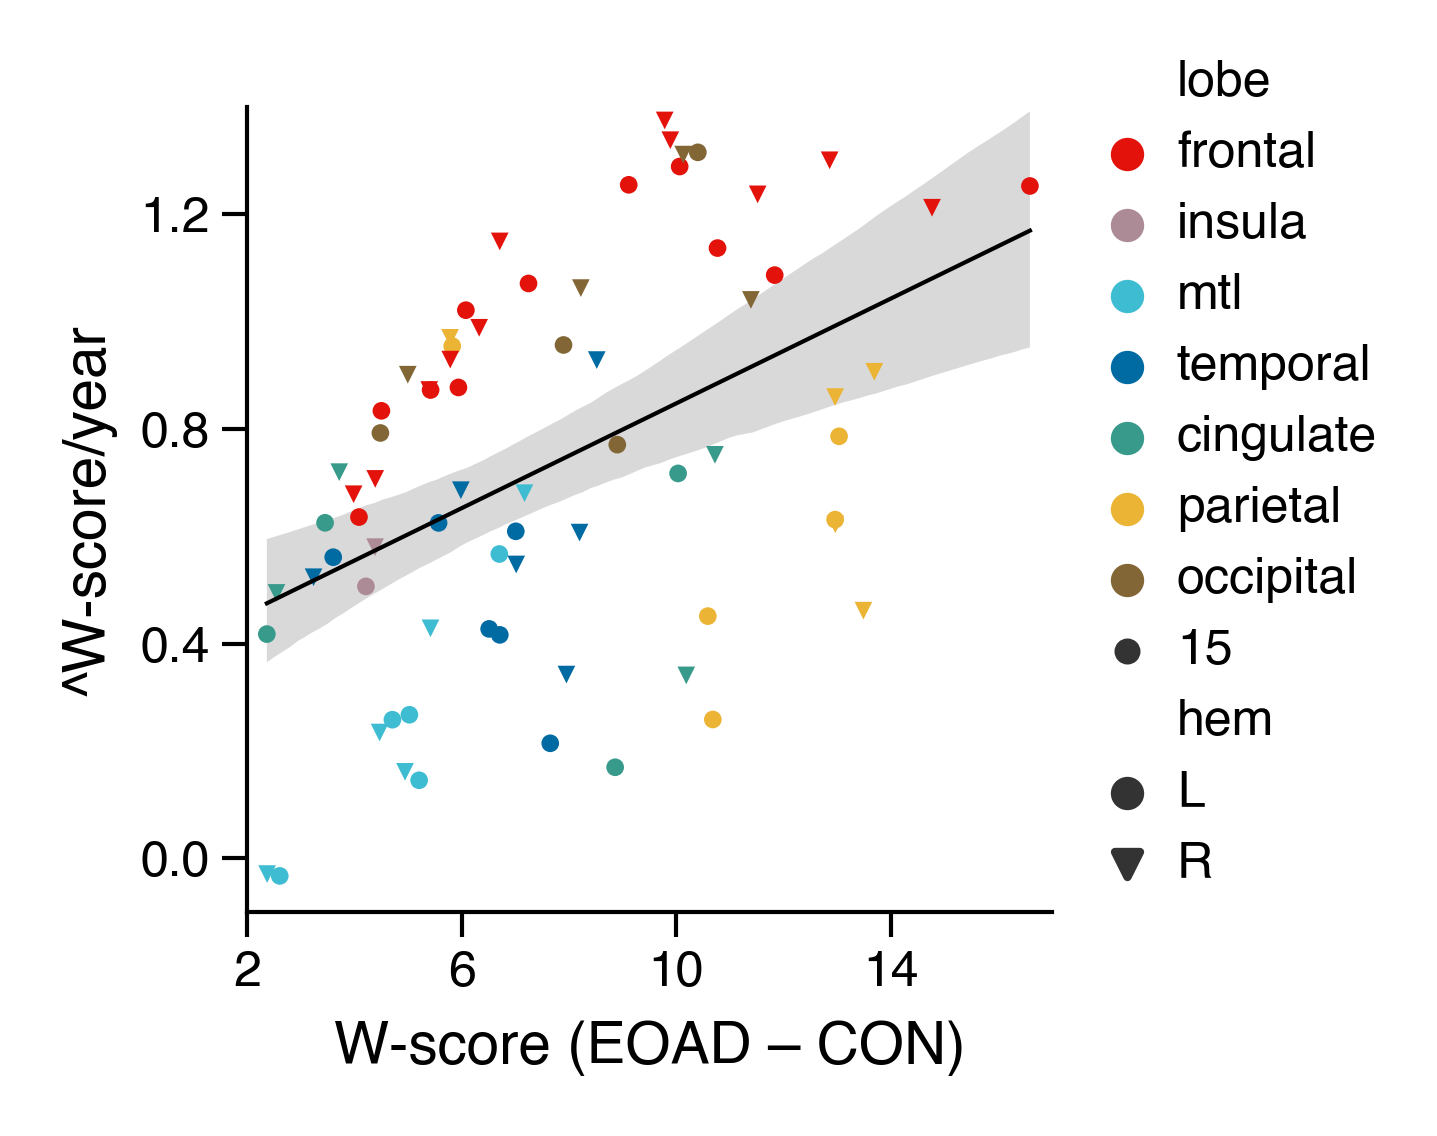

In [237]:
figsize = (colws[1], colws[1] * 0.85)
dpi = 600
alpha = 0.5
lw = 0.5
size = 15
xlim = [2, 17]
xticks = [2, 6, 10, 14]
ylim = [-0.1, 1.4]
yticks = [0, 0.4, 0.8, 1.2]
ticklen = 3
tickwidth = 0.5
tickpad = 1.5
labelpad = 3
colors = [co['r'], co['lm'], co['c'], co['b'], co['g'], co['y'], co['a5']]
savefig = False
overwrite = True
# ------------------

plt.close("all")
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
ax = np.ravel(ax)

iax = 0
_ax = ax[iax]
_ax = sns.regplot(
    data=merged_df,
    ax=_ax,
    x="est.x",
    y="est.y",
    scatter=False,
    color='k',
    line_kws={"lw": lw},
)
_ax = sns.scatterplot(
    data=merged_df,
    ax=_ax,
    x="est.x",
    y="est.y",
    hue="lobe",
    style="hem",
    palette=colors,
    size=size,
    markers=['o', 'v'],
    # color="#B7C6CF",
    linewidth=0,
)
_ax.set_aspect((np.diff(xlim) / np.diff(ylim))[0])
_ax.spines[["bottom", "left"]].set_linewidth(lw)
_ax.tick_params(
    labelsize=font["tick"],
    length=ticklen,
    width=tickwidth,
    pad=tickpad,
)
_ax.set_xlim(xlim)
_ax.set_xticks(xticks)
_ax.set_ylim(ylim)
_ax.set_yticks(yticks)
_ax.set_xlabel("W-score (EOAD – CON)", fontsize=font["label"], labelpad=labelpad)
_ax.set_ylabel("^W-score/year", fontsize=font["label"], labelpad=labelpad)

leg = _ax.legend(
    loc="lower left",
    bbox_to_anchor=(1, 0),
    fontsize=font["tick"],
    borderpad=0,
    handletextpad=0,
    title=None
)
if savefig:
    filename = op.join(proj_dir, 'figs', 'baseline_tau_vs_change_in_tau_by_region.png')
    if overwrite or not op.exists(filename):
        fig.savefig(filename, dpi=dpi, bbox_inches="tight", pad_inches=0.1)
        fig.savefig(filename.replace(".png", ".pdf"), bbox_inches="tight", pad_inches=0)
        print("Saved {}".format(filename))

In [140]:
writeval = 'est'
save_output = True
overwrite = True
# ----------------------------

for hem in ['L', 'R']:
    # dat = np.zeros(aparc_dat.shape)
    # for idx, row in coef_eoad_con_bline.query("(hem=='{}')".format(hem)).iterrows():
    #     dat[(aparc_dat==row['label'])] = row[writeval]
    # if save_output:
    #     outf = op.join(proj_dir, 'analysis', 'freesurfer_roi_betas',
    #                    'coef_eoad_con_bline-{}-{}-{}.nii.gz'.format(row['coef'], writeval, hem))
    #     nops.save_nii(aparc_img, dat, outf, overwrite)
    
    for sign in ['pos', 'neg']:
        dat = np.zeros(aparc_dat.shape)
        if sign == 'pos':
            qry = "(coef=='years_from_baseline_pet') & (hem=='{}') & (est>0)".format(hem)
        else:
            qry = "(coef=='years_from_baseline_pet') & (hem=='{}') & (est<0)".format(hem)
        df = coef_eoad_time.query(qry)
        if len(df) > 0:
            for idx, row in df.iterrows():
                # if row['sig_fdr']:
                if sign == 'pos':
                    dat[(aparc_dat==row['label'])] = row[writeval]
                else:
                    dat[(aparc_dat==row['label'])] = -row[writeval]
            if save_output:
                outf = op.join(proj_dir, 'analysis', 'freesurfer_roi_betas',
                               'coef_eoad_time-{}-{}-{}-{}.nii.gz'.format(row['coef'], writeval, sign, hem))
                nops.save_nii(aparc_img, dat, outf, overwrite)
        
    # for coef in ['cdrsob_gt4TRUE', 'years_from_baseline_pet:cdrsob_gt4TRUE']:
    #     dat = np.zeros(aparc_dat.shape)
    #     for idx, row in coef_eoad_time_cdrgt4.query("(coef=='{}') & (hem=='{}')".format(coef, hem)).iterrows():
    #         dat[(aparc_dat==row['label'])] = row[writeval]
    #     if save_output:
    #     outf = op.join(proj_dir, 'analysis', 'freesurfer_roi_betas',
    #                    'coef_eoad_time_cdrgt4-{}-{}-{}.nii.gz'.format(row['coef'], writeval, hem))
    #     nops.save_nii(aparc_img, dat, outf, overwrite)

Saved /Users/dschonhaut/box/projects/leads_tau_spread/analysis/freesurfer_roi_betas/coef_eoad_time-years_from_baseline_pet-est-pos-L.nii.gz
Saved /Users/dschonhaut/box/projects/leads_tau_spread/analysis/freesurfer_roi_betas/coef_eoad_time-years_from_baseline_pet-est-neg-L.nii.gz
Saved /Users/dschonhaut/box/projects/leads_tau_spread/analysis/freesurfer_roi_betas/coef_eoad_time-years_from_baseline_pet-est-pos-R.nii.gz
Saved /Users/dschonhaut/box/projects/leads_tau_spread/analysis/freesurfer_roi_betas/coef_eoad_time-years_from_baseline_pet-est-neg-R.nii.gz


In [141]:
# for idx, row in coef_eoad_con_bline.iterrows():
#     print(row['hemroi'], row['label'], np.sum(aparc_dat[(aparc_dat==row['label'])]))

In [242]:
coef_eoad_time_cdrgt4['coef'].value_counts()

(Intercept)                               72
years_from_baseline_pet                   72
cdrsob_gt4TRUE                            72
years_from_baseline_pet:cdrsob_gt4TRUE    72
Name: coef, dtype: int64

In [245]:
coef_merged_cdr_bline = pd.merge(coef_eoad_time_cdrgt4.query("(coef=='(Intercept)')"),
                                 coef_eoad_time_cdrgt4.query("(coef=='cdrsob_gt4TRUE')"),
                                 on='hemroi')
coef_merged_cdr_slope = pd.merge(coef_eoad_time_cdrgt4.query("(coef=='years_from_baseline_pet')"),
                                 coef_eoad_time_cdrgt4.query("(coef=='years_from_baseline_pet:cdrsob_gt4TRUE')"),
                                 on='hemroi')
coef_merged_cdr_bline['est_mci'] = coef_merged_cdr_bline['est_x']
coef_merged_cdr_bline['est_dem'] = coef_merged_cdr_bline['est_x'] + coef_merged_cdr_bline['est_y']
coef_merged_cdr_slope['est_mci'] = coef_merged_cdr_slope['est_x']
coef_merged_cdr_slope['est_dem'] = coef_merged_cdr_slope['est_x'] + coef_merged_cdr_slope['est_y']

,hemroi,hem_x,label_x,nrow_x,coef_x,est_x,sem_x,ci2.5_x,ci97.5_x,df_x,tval_x,pval_x,pval_fdr_x,sig_fdr_x,hem_y,label_y,nrow_y,coef_y,est_y,sem_y,ci2.5_y,ci97.5_y,df_y,tval_y,pval_y,pval_fdr_y,sig_fdr_y
0,L_frontalpole,L,1032,369,(Intercept),4.323599,0.507471,3.340210,5.256377,210.846689,8.519900,3.047453e-15,3.718926e-15,True,L,1032,369,cdrsob_gt4TRUE,3.526323,0.864521,1.784059,5.027126,210.962083,4.078931,6.413338e-05,7.961385e-05,True
1,L_medialorbitofrontal,L,1014,369,(Intercept),3.163719,0.351187,2.486953,3.847818,213.841164,9.008641,1.180058e-16,1.517218e-16,True,L,1014,369,cdrsob_gt4TRUE,2.687555,0.598317,1.560508,3.905405,214.011564,4.491858,1.154627e-05,1.807242e-05,True
2,L_lateralorbitofrontal,L,1012,369,(Intercept),4.635198,0.440258,3.821047,5.495925,211.701303,10.528363,4.071426e-21,5.747895e-21,True,L,1012,369,cdrsob_gt4TRUE,3.711611,0.750032,2.100343,5.234494,211.830983,4.948606,1.522396e-06,3.522368e-06,True
3,L_parsorbitalis,L,1019,369,(Intercept),4.895376,0.481184,3.967419,5.843862,212.323591,10.173598,4.662276e-20,6.333658e-20,True,L,1019,369,cdrsob_gt4TRUE,3.598069,0.819768,2.079407,5.183237,212.468044,4.389129,1.792916e-05,2.689373e-05,True
4,L_parstriangularis,L,1020,369,(Intercept),7.305955,0.625888,6.144815,8.452585,210.137970,11.672942,1.357016e-24,2.272213e-24,True,L,1020,369,cdrsob_gt4TRUE,4.885709,1.066262,2.714413,7.056737,210.258101,4.582092,7.886907e-06,1.290585e-05,True
5,L_parsopercularis,L,1018,369,(Intercept),8.723506,0.631014,7.455208,10.022665,210.910464,13.824594,2.260862e-31,5.086939e-31,True,L,1018,369,cdrsob_gt4TRUE,5.495241,1.075007,3.175682,7.581259,211.041635,5.111817,7.138136e-07,2.607371e-06,True
6,L_rostralmiddlefrontal,L,1027,369,(Intercept),9.563438,0.717450,8.291922,11.084878,210.265215,13.329768,8.735929e-30,1.849961e-29,True,L,1027,369,cdrsob_gt4TRUE,6.519219,1.222239,4.191296,8.666093,210.380358,5.333834,2.475354e-07,1.782255e-06,True
7,L_superiorfrontal,L,1028,369,(Intercept),8.075971,0.645241,6.944515,9.398794,210.688730,12.516204,3.079554e-27,5.685330e-27,True,L,1028,369,cdrsob_gt4TRUE,5.887125,1.099240,3.475007,8.017886,210.815271,5.355632,2.222518e-07,1.782255e-06,True
8,L_caudalmiddlefrontal,L,1003,369,(Intercept),13.931707,0.826135,12.223344,15.585303,211.713655,16.863724,5.128379e-41,1.758301e-40,True,L,1003,369,cdrsob_gt4TRUE,7.669950,1.407457,5.067116,10.359890,211.867787,5.449508,1.396891e-07,1.782255e-06,True
9,L_precentral,L,1024,369,(Intercept),5.612639,0.542062,4.494233,6.694211,208.526570,10.354235,1.541685e-20,2.134640e-20,True,L,1024,369,cdrsob_gt4TRUE,3.971104,0.923430,2.114157,5.828828,208.622711,4.300386,2.617774e-05,3.695681e-05,True
